In [1]:
# These are combined responses of autofluorescence, Ca sensor (EGFP), and DA sensor (mApple).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import pandas as pd
from rich import print as pprint
from sourcesep.utils.config import load_config
from tqdm import tqdm
from aind_ophys_utils.dff import dff

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

In [2]:
from sourcesep.sim import SimData
paths = load_config(dataset_key='all')
sim = SimData(T=10000, cfg_path=paths['root'] / "sim_HSFP_636970_2022-11-14-12-34-14.toml")
_ = sim.get_S()
_ = sim.get_W()
_ = sim.get_E()
pprint(sim.W_df)

Paths are for dataset tagged: all
Paths are for dataset tagged: all


405     473     561
EGFP    0.1732  0.8143  0.0043
mApple  0.0069  0.0920  0.8972

In [3]:
paths = load_config(dataset_key='all')
f = h5py.File(paths['root'] / 'HSFP_636970_2022-11-14-12-34-14_data_preprocessed.hdf5', 'r')
print(f.keys())

xj = {}
xj[0] = f['Channel3'][:].astype(float) #405
xj[1] = f['Channel2'][:].astype(float) #473
xj[2] = f['Channel1'][:].astype(float) #560

t = f['Time'][:]
l = f['Wavelength'][:]

print(f'\nsampling frequency: {1/(np.max(t) / t.size):0.2f} Hz')
print(f'length of recording: {np.max(t)-np.min(t):0.2f} seconds')
print(f'\neach channel has dimensions of {xj[0].shape}')
print(f'min. wavelength: {np.min(l):0.2f} nm')
print(f'max. wavelength: {np.max(l):0.2f} nm')

Paths are for dataset tagged: all
<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Time', 'Wavelength']>

sampling frequency: 40.00 Hz
length of recording: 441.64 seconds

each channel has dimensions of (17666, 300)
min. wavelength: 400.00 nm
max. wavelength: 699.00 nm


In [4]:
# laser intensity (close to emission peak of laser) is orders of magnitude
# larger than the signal intensity from indicators (close to emission peak of fluorophore).
# here we use aind utils to obtain the df/f and f0 signals independently for each pixel in each channel.

rel_xj = {}
f0_xj = {}
mean_per_px = {}

for j in range(len(xj)):
    dff_signal_list = []
    f0_signal_list = []
    for px in tqdm(range(xj[j].shape[1])):
        dff_signal, f0_signal, signal_sd = dff(xj[j][:,px], 
                                               fs=23.99, 
                                               long_window=20.0, 
                                               short_window=2.0, 
                                               inactive_percentile=5)
        # check if nan in dff_signal, set to a very small value if so
        if np.isnan(dff_signal).any():
            dff_signal = np.zeros(dff_signal.shape) + 1e-6*np.random.randn(dff_signal.shape[0])
        dff_signal = dff_signal + np.abs(np.min(dff_signal[dff_signal<0])) # if negative, push to 0
        dff_signal_list.append(dff_signal)
        f0_signal_list.append(f0_signal)
    
    rel_xj[j] = np.vstack(dff_signal_list).T
    f0_xj[j] = np.vstack(f0_signal_list).T

100%|██████████| 300/300 [00:08<00:00, 36.99it/s]


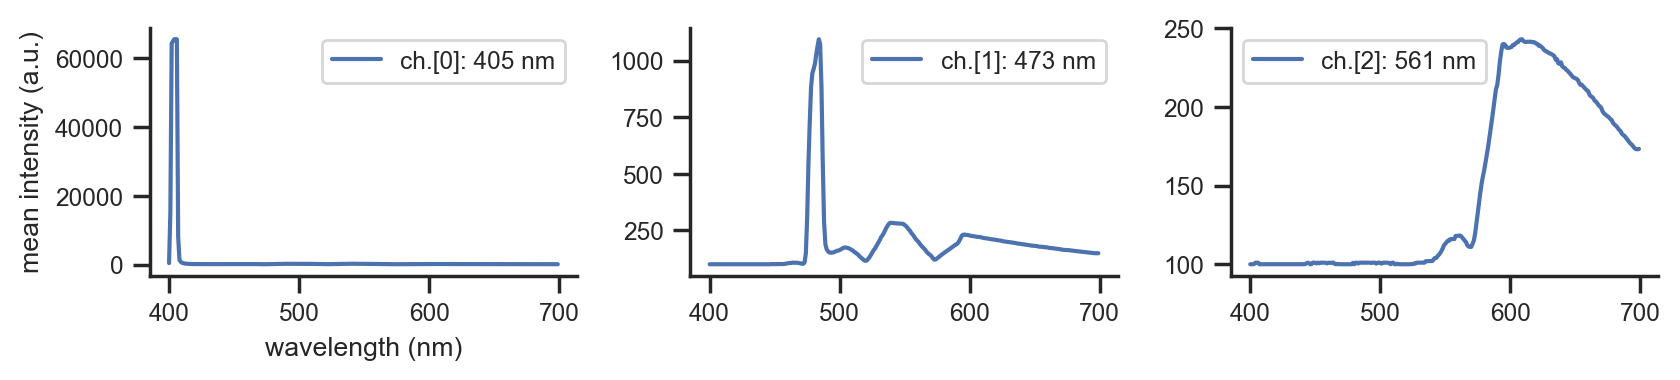

In [5]:
# plot the raw data mean per pixel
f, ax = plt.subplots(1, len(xj), figsize=(8.5, 2))
lasers_inferred = [405, 473, 561]
for j in range(len(xj)):
    ax[j].plot(l, np.squeeze(np.mean(f0_xj[j], axis=0)), label=f'ch.[{j}]: {lasers_inferred[j]} nm')
    ax[j].legend()
    if j == 0:
        ax[j].set(xlabel = 'wavelength (nm)', ylabel = 'mean intensity (a.u.)')

plt.tight_layout()
plt.show()

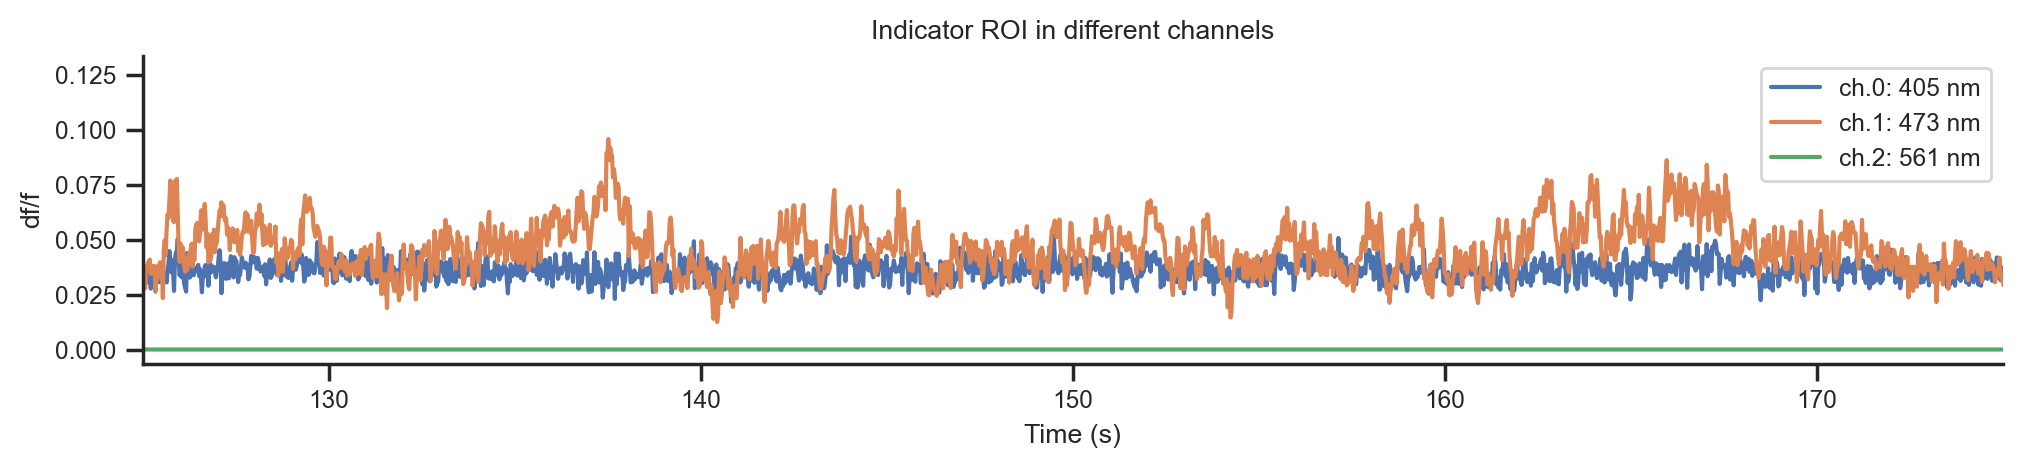

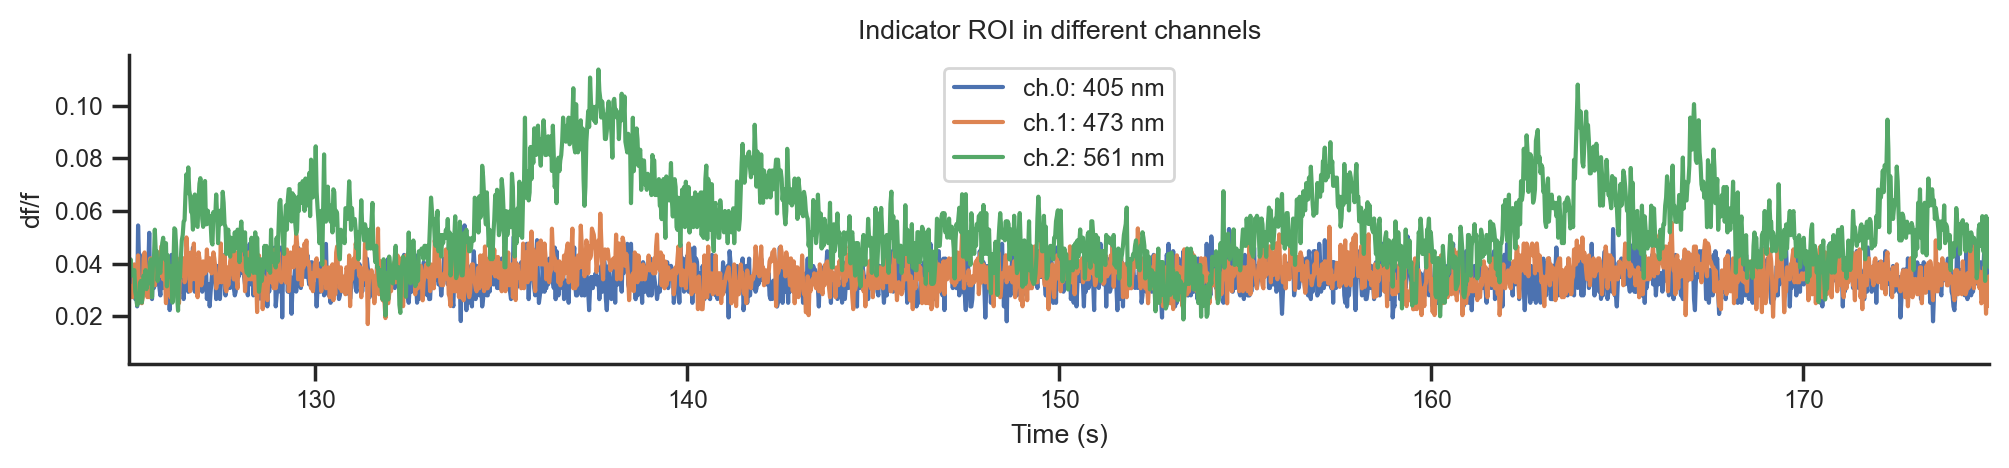

In [6]:
roi_laser = [(402,409),
             (495,515),
             (545,563)]
# based on annotations / regions chosen for the single indicator data

for j in range(len(roi_laser)):
    roi_laser[j] = np.where(np.logical_and(l>roi_laser[j][0], l<roi_laser[j][1]))[0]

roi_indicator_ca= np.where(np.logical_and(l>530, l<540))[0]
roi_indicator_da = np.where(np.logical_and(l>605, l<610))[0]


# there is only one indicator, so we'll look at the same roi in different channels
for roi_ in [roi_indicator_ca, roi_indicator_da]:
    f, ax = plt.subplots(1,1,figsize = (12,2))
    for j in range(len(rel_xj)):
        avg_roi_rel = np.mean(rel_xj[j][:,roi_], axis=1).squeeze()
        ax.plot(t, avg_roi_rel, label=f'ch.{j}: {lasers_inferred[j]} nm')
        ax.set(xlim = (125, 175), xlabel = 'Time (s)', title='Indicator ROI in different channels', ylabel = 'df/f')
    plt.legend()
    plt.show()

In [7]:
avg_signal_laser = {}
for j in range(len(roi_laser)):
    avg_signal_laser[j] = np.mean(rel_xj[j][:,roi_laser[j]], axis=1).squeeze()


avg_signal_indicator_ca = np.mean(rel_xj[1][:,roi_indicator_ca], axis=1).squeeze()
avg_signal_indicator_da = np.mean(rel_xj[2][:,roi_indicator_da], axis=1).squeeze()


In [8]:
sources = [*[avg_signal_laser[j] for j in range(len(xj))], avg_signal_indicator_ca, avg_signal_indicator_da]
corr = np.corrcoef(sources)

src_label = ['laser 405 nm', 'laser 473 nm', 'laser 561 nm', 'Ca', 'Da']
df_corr = pd.DataFrame(np.round(corr, 2), columns=src_label, index=src_label)
df_corr


laser 405 nm  laser 473 nm  laser 561 nm    Ca    Da
laser 405 nm          1.00         -0.24          0.05 -0.31 -0.04
laser 473 nm         -0.24          1.00         -0.05  0.89  0.23
laser 561 nm          0.05         -0.05          1.00 -0.06  0.25
Ca                   -0.31          0.89         -0.06  1.00  0.21
Da                   -0.04          0.23          0.25  0.21  1.00

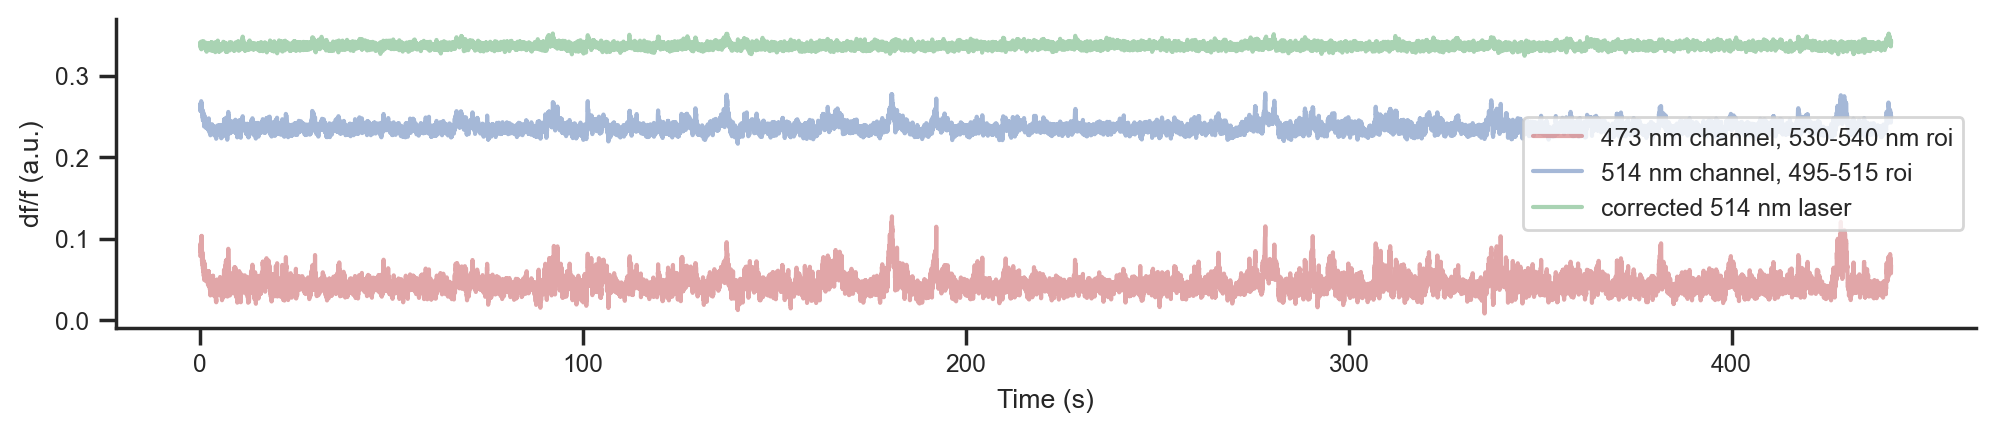

In [9]:
# removing the correlated component
a = np.copy(avg_signal_laser[1])
b = np.copy(avg_signal_indicator_ca)
a_avg = np.mean(a)
b_avg = np.mean(b)
a = a - a_avg
b = b - b_avg
uncorr_laser_src = (a - np.dot(a,b)/np.dot(b,b) * b) + a_avg

f, ax = plt.subplots(1,1,figsize = (12,2))

ax.plot(t, np.squeeze(avg_signal_indicator_ca), 'r', alpha=0.5, label='473 nm channel, 530-540 nm roi')
ax.plot(t, np.squeeze(avg_signal_laser[1]) + 0.2, 'b', alpha=0.5, label='514 nm channel, 495-515 roi')
ax.plot(t, np.squeeze(uncorr_laser_src) + 0.3, 'g', alpha=0.5, label='corrected 514 nm laser')
ax.set(xlabel='Time (s)', ylabel='df/f (a.u.)')
plt.legend()
plt.show()

# plots are staggered just for comparison

In [10]:
sources = [*[avg_signal_laser[j] for j in range(len(xj))], avg_signal_indicator_ca, avg_signal_indicator_da]
sources[1] = uncorr_laser_src
corr = np.corrcoef(sources)

src_label = ['laser 405 nm', 'laser 473 nm', 'laser 561 nm', 'Ca', 'Da']
df_corr = pd.DataFrame(np.round(corr, 2), columns=src_label, index=src_label)
df_corr


laser 405 nm  laser 473 nm  laser 561 nm    Ca    Da
laser 405 nm          1.00          0.07          0.05 -0.31 -0.04
laser 473 nm          0.07          1.00         -0.01  0.00  0.09
laser 561 nm          0.05         -0.01          1.00 -0.06  0.25
Ca                   -0.31          0.00         -0.06  1.00  0.21
Da                   -0.04          0.09          0.25  0.21  1.00

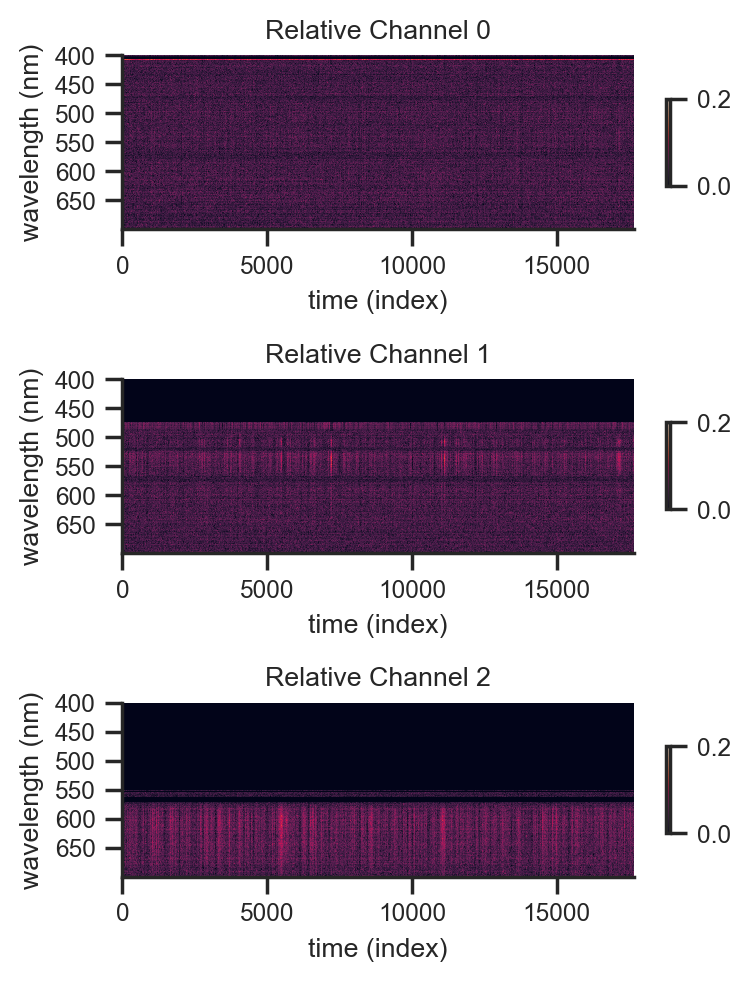

In [11]:
# Check normalized data across different channels
f, ax = plt.subplots(3, 1, figsize=(4, 5))
for j in range(3):
    f.colorbar(ax[j].imshow(rel_xj[j].T, interpolation='nearest', aspect='auto', vmin=0, vmax=0.2), ax=ax[j], shrink=0.5)
    ax[j].grid(visible=False)
    ax[j].set(ylabel='wavelength (nm)', xlabel='time (index)', title=f'Relative Channel {j}')
    ax[j].set_yticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])

plt.tight_layout()

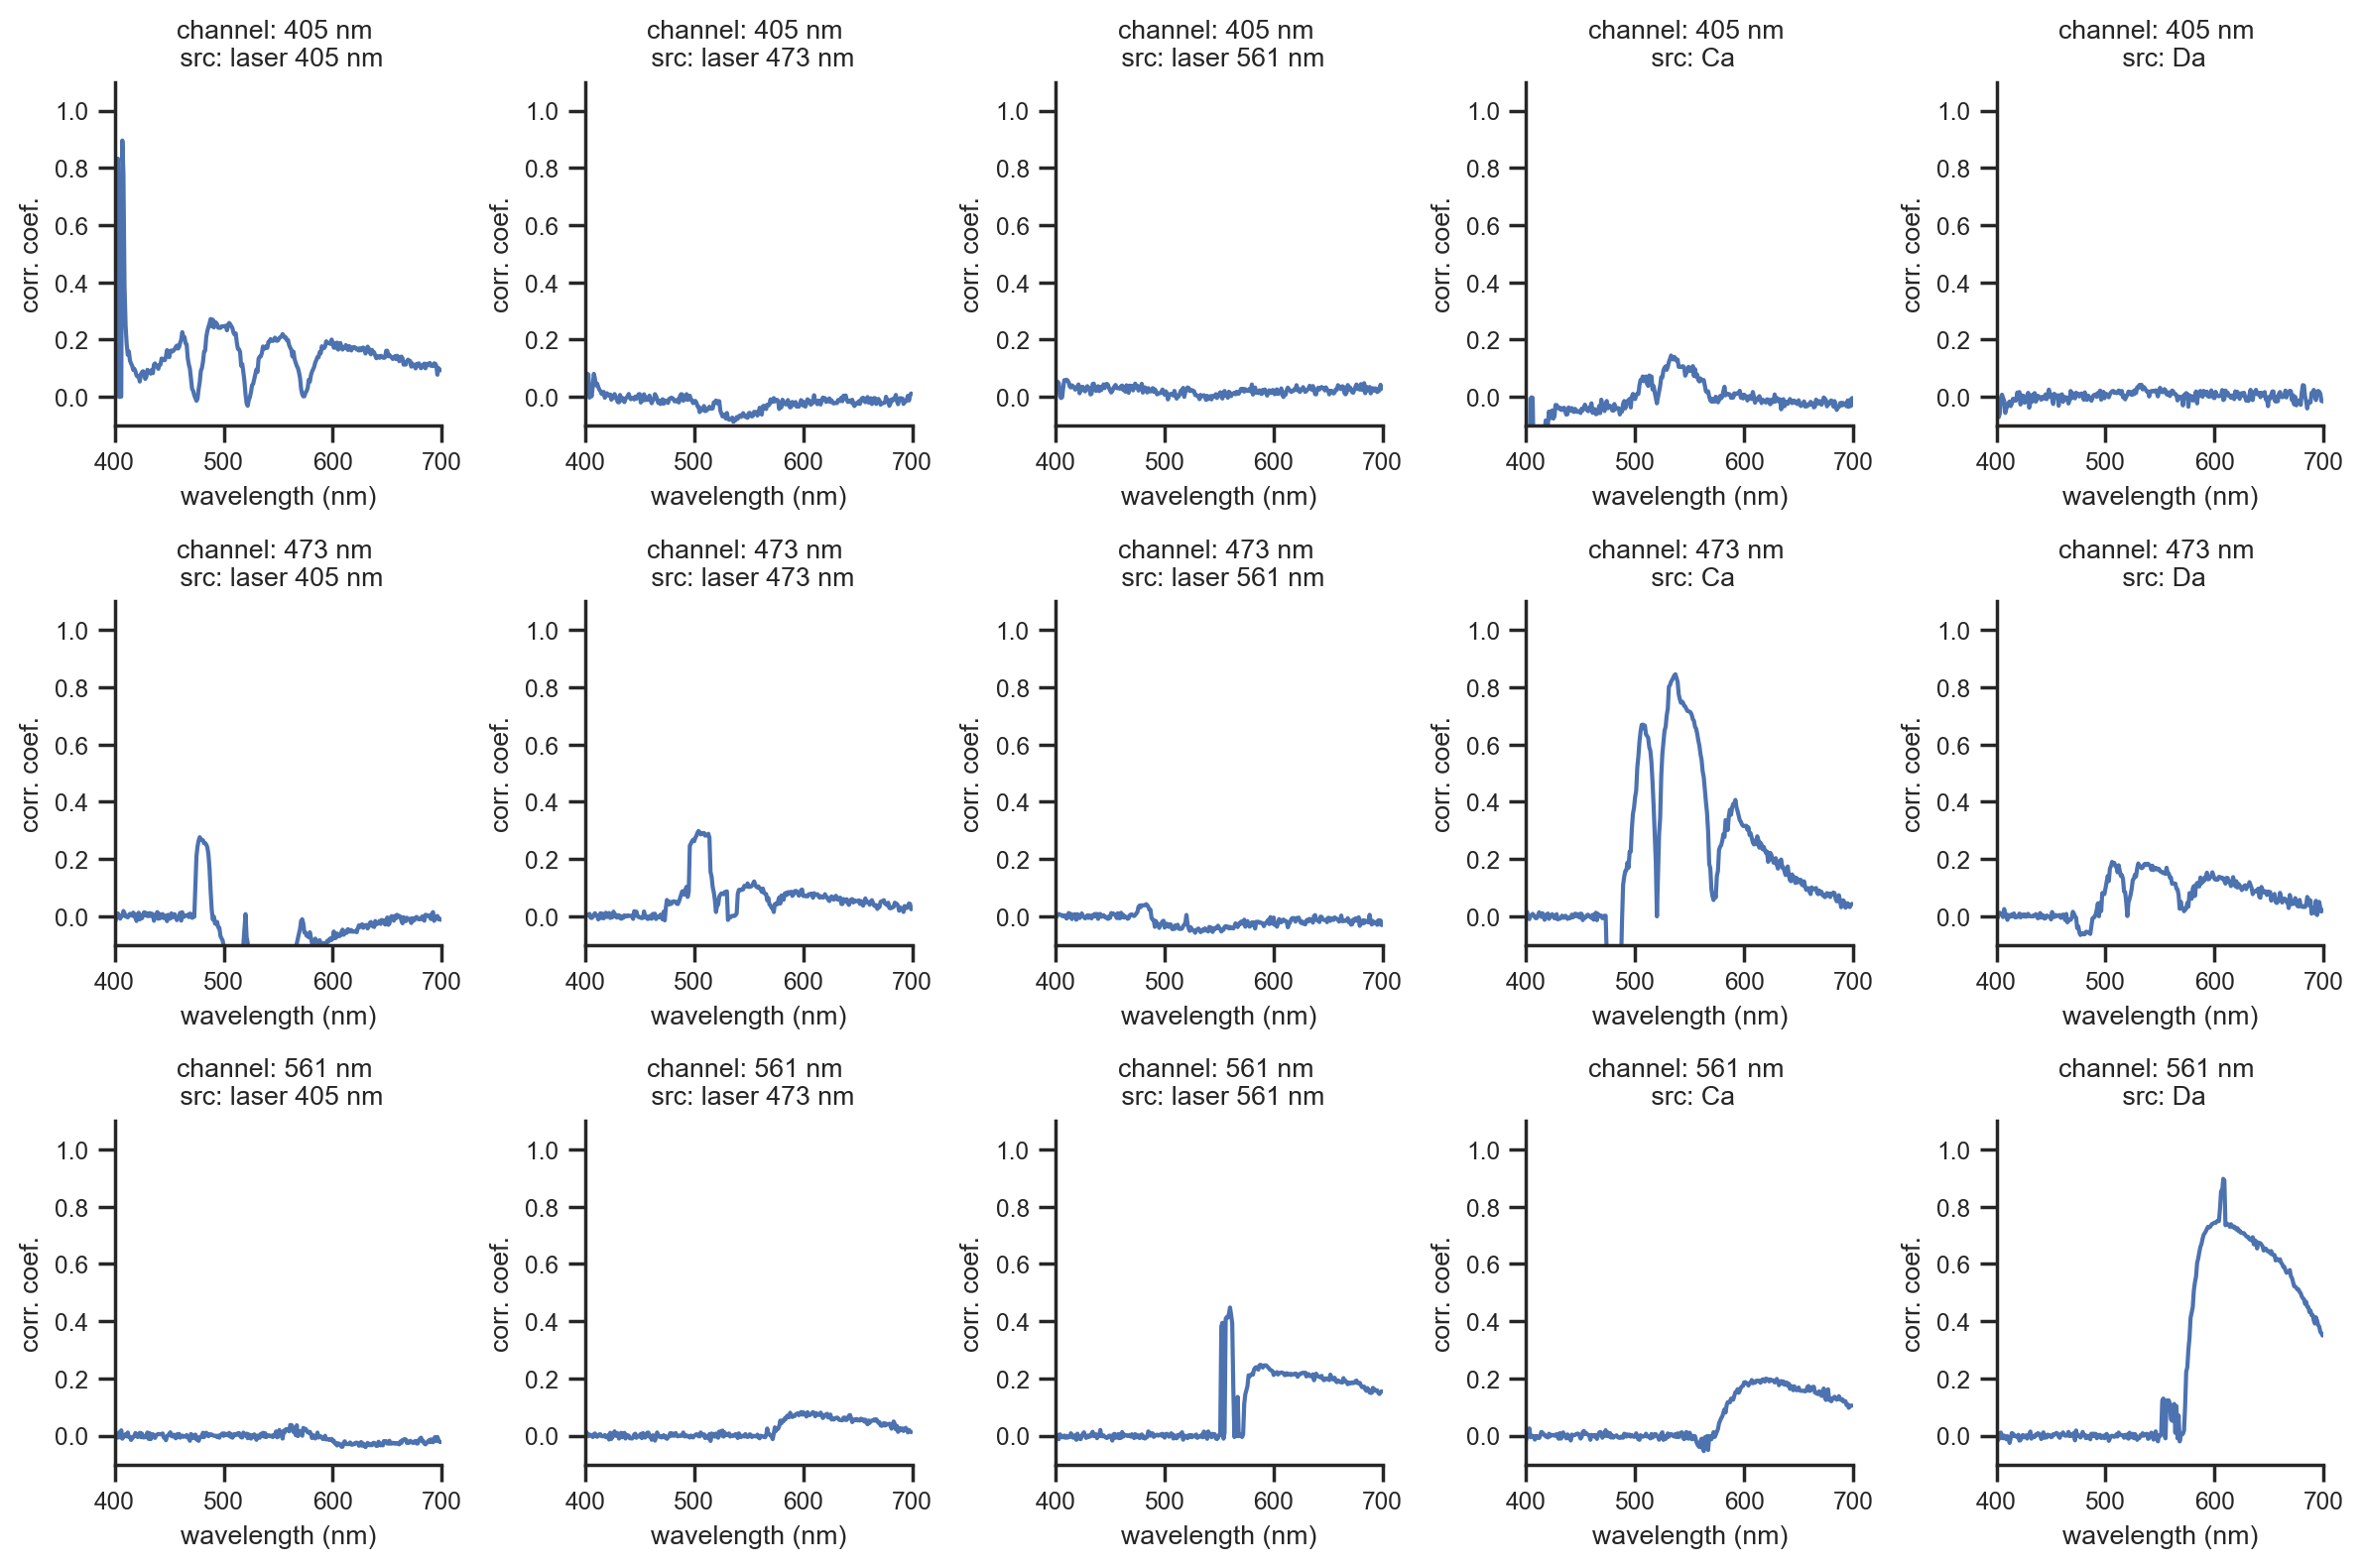

In [12]:
# we have starting points for source signals based on roi
# we'll estimate the mixing matrix, by looking at correlation between sources and channels

def coef_fn(x, y):
    c = np.dot(x - np.mean(x), y - np.mean(y)) / np.size(x)
    c = c / (np.std(x)*np.std(y) + 1e-10)
    return c


src_label = ['laser 405 nm', 'laser 473 nm', 'laser 561 nm', 'Ca', 'Da']
lasers = ['laser 405 nm', 'laser 473 nm', 'laser 561 nm']
n_channels = 3

f, ax = plt.subplots(len(lasers), len(src_label), figsize=(12, 8))
W_list = [[] for _ in range(n_channels)]


for col, src in enumerate(sources):
    for j in range(n_channels):
        src_cc = np.array([coef_fn(src, rel_xj[j][:, px]) for px in range(rel_xj[j].shape[1])])

        # force zeros
        #if (j < 3) and (col < 3):
        #    if j != col:
        #        src_cc = np.zeros_like(src_cc)

        W_list[j].append(src_cc)
        ax[j, col].plot(l, src_cc, '-b')
        ax[j, col].set(xlim=(400, 700),
                       ylim=(-0.1, 1.1),
                       title=f'channel: {lasers_inferred[j]} nm \n src: {src_label[col]}',
                       xlabel='wavelength (nm)',
                       ylabel='corr. coef.',)
plt.tight_layout()
plt.show()

[(550.0, 600.0)]

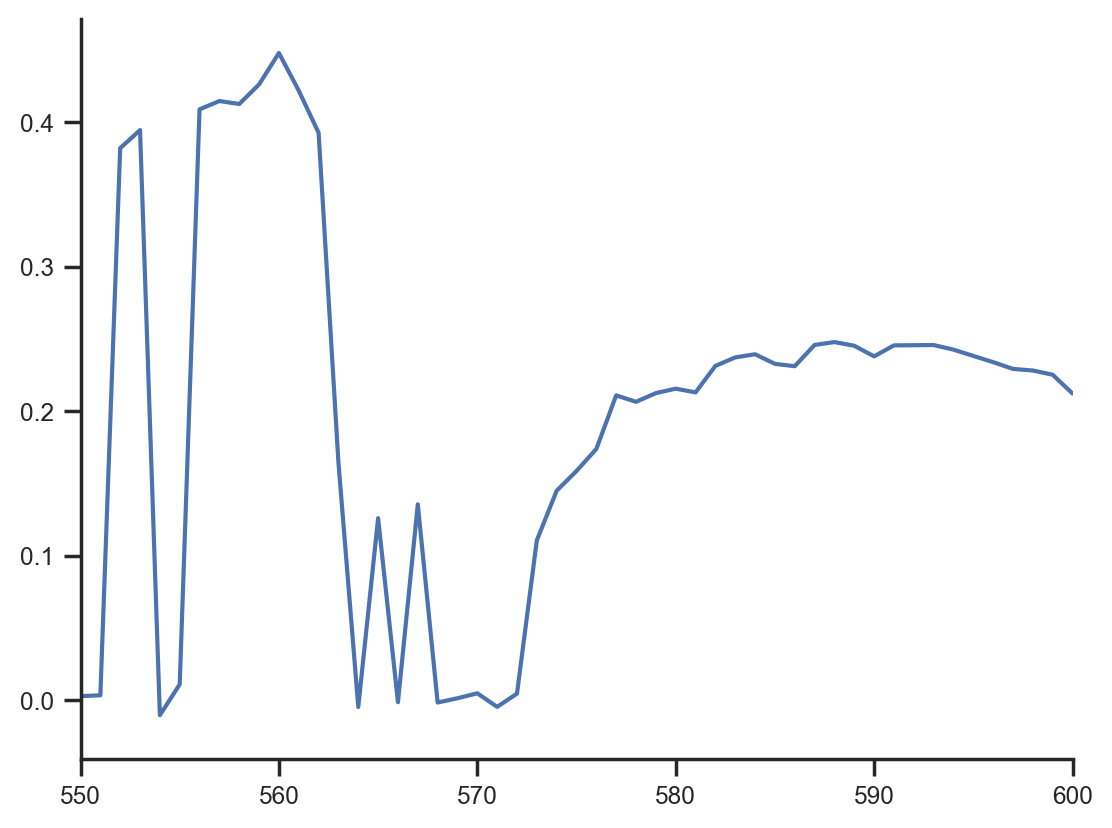

In [13]:
plt.plot(l, W_list[2][2])
ax = plt.gca()
ax.set(xlim=(550, 600))


In [14]:
# include channels [0,1,2]; 
# sources [0,1,2], and an extra one for autofluorescence
# for each channel retain only pixels in the 460 to 650 nm range

sel_channels = [0,1,2]
sel_px_channel = {}
sel_px_channel[0] = np.logical_and(l>=460, l<=650)
sel_px_channel[1] = np.logical_and(l>=460, l<=650)
sel_px_channel[2] = np.logical_and(l>=550, l<=700)

l_channels = {}
n_px_in_ch = {}
for ch in sel_channels:
    l_channels[ch] = l[sel_px_channel[ch]]
    n_px_in_ch[ch] = np.size(l_channels[ch])

sel_sources = [0,1,2]
n_sources = 6 # 3 lasers + 2 indicators + 1 autofluorescence

YY = np.concatenate([rel_xj[j][:,sel_px_channel[j]] for j in sel_channels], axis=1)
YY = YY.T
print('data shape:', YY.shape)

data shape: (532, 17666)


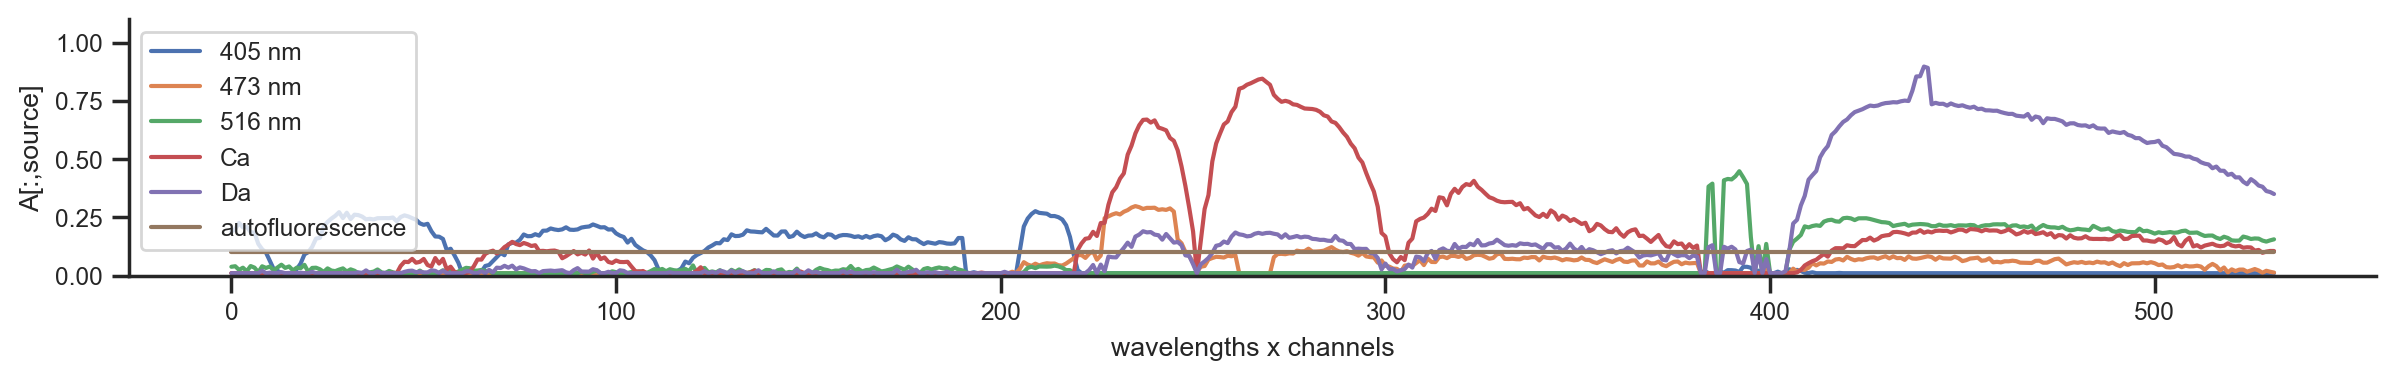

In [15]:
AA = 0.1*np.ones((YY.shape[0], n_sources))

AA[:,0] = np.concatenate([W_list[c][0][sel_px_channel[c]] for c in [0,1,2]], axis=0)
AA[:,1] = np.concatenate([W_list[c][1][sel_px_channel[c]] for c in [0,1,2]], axis=0)
AA[:,2] = np.concatenate([W_list[c][2][sel_px_channel[c]] for c in [0,1,2]], axis=0)
AA[:,3] = np.concatenate([W_list[c][3][sel_px_channel[c]] for c in [0,1,2]], axis=0) # Ca indicator
AA[:,4] = np.concatenate([W_list[c][4][sel_px_channel[c]] for c in [0,1,2]], axis=0) # Ca indicator

AA[AA<0.01] = 0.01

f, ax = plt.subplots(figsize=(12,2))
ax.plot(AA[:,0], label='405 nm')
ax.plot(AA[:,1], label='473 nm')
ax.plot(AA[:,2], label='516 nm')
ax.plot(AA[:,3], label='Ca')
ax.plot(AA[:,4], label='Da')
ax.plot(AA[:,5], label='autofluorescence')
ax.set(xlabel='wavelengths x channels', ylabel='A[:,source]', ylim=(0.0,1.1))
plt.legend()
plt.tight_layout()
plt.show()

(532, 6)


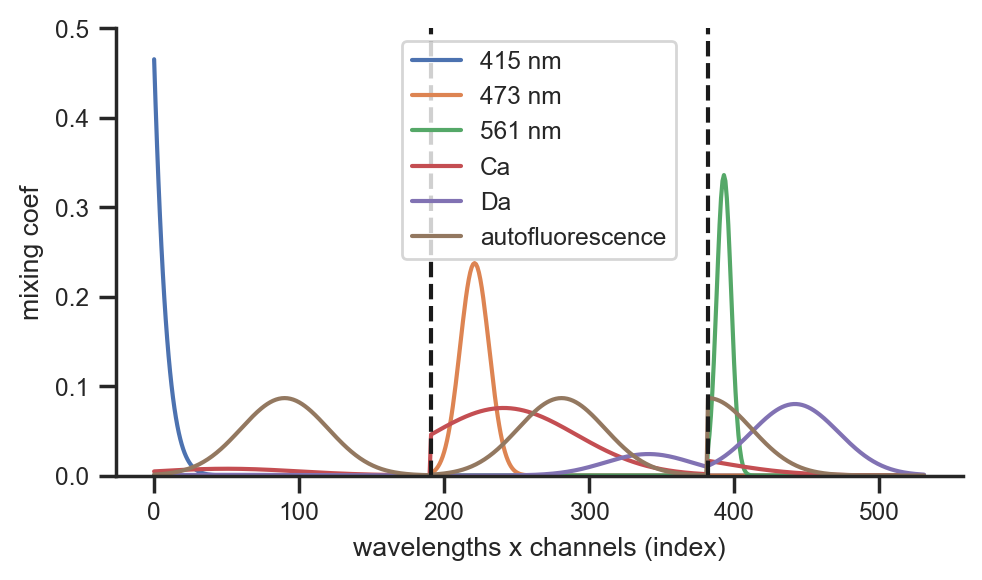

In [16]:
from scipy.stats import norm
from sourcesep.models.nmf_variants import set_norm

x = np.concatenate([l_channels[0], l_channels[1], l_channels[2]])

l1 = norm.pdf(x, loc=415, scale=20)
l1[n_px_in_ch[0]:] = 0
l1 = set_norm(l1, axis=0, c=1)[0]


l2 = norm.pdf(x, loc=490, scale=10)
l2[:n_px_in_ch[0]] = 0
l2[(n_px_in_ch[0]+n_px_in_ch[1]):] = 0
l2 = set_norm(l2, axis=0, c=1)[0]

l3 = norm.pdf(x, loc=561, scale=5)
l3[:(n_px_in_ch[0]+n_px_in_ch[1])] = 0
l3 = set_norm(l3, axis=0, c=1)[0]

indicator_ca = norm.pdf(x, loc=510, scale=50)
indicator_ca = set_norm(indicator_ca, axis=0, c=1)[0]
indicator_ca[:n_px_in_ch[0]] = indicator_ca[:n_px_in_ch[0]]*0.1 # 415 nm laser channel
indicator_ca[(n_px_in_ch[0]+n_px_in_ch[1]):] = indicator_ca[(n_px_in_ch[0]+n_px_in_ch[1]):]*0.3 # 561 nm laser channel

indicator_da = norm.pdf(x, loc=610, scale=30)
indicator_da = set_norm(indicator_da, axis=0, c=1)[0]
indicator_da[:n_px_in_ch[0]] = indicator_ca[:n_px_in_ch[0]]*0.1
indicator_da[n_px_in_ch[0]:(n_px_in_ch[0]+n_px_in_ch[1])] = indicator_da[n_px_in_ch[0]:(n_px_in_ch[0]+n_px_in_ch[1])]*0.3

autofl = norm.pdf(x, loc=550, scale=30)
autofl = set_norm(autofl, axis=0, c=1)[0]

f, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(np.arange(x.size), l1, label='415 nm')
ax.plot(np.arange(x.size), l2, label='473 nm')
ax.plot(np.arange(x.size), l3, label='561 nm')
ax.plot(np.arange(x.size), indicator_ca, label='Ca')
ax.plot(np.arange(x.size), indicator_da, label='Da')
ax.plot(np.arange(x.size), autofl, label='autofluorescence')

ax.axvline(n_px_in_ch[0], color='k', linestyle='--')
ax.axvline(n_px_in_ch[0]+n_px_in_ch[1], color='k', linestyle='--')

ax.set(xlabel='wavelengths x channels (index)',
       ylabel='mixing coef', 
       ylim=(0.0, 0.5))
plt.legend()
plt.tight_layout()

A_init_0 = np.vstack([l1, l2, l3, indicator_ca, indicator_da, autofl]).T
A_init_0 = set_norm(A_init_0, axis=0, c=1.0)[0]
print(A_init_0.shape)


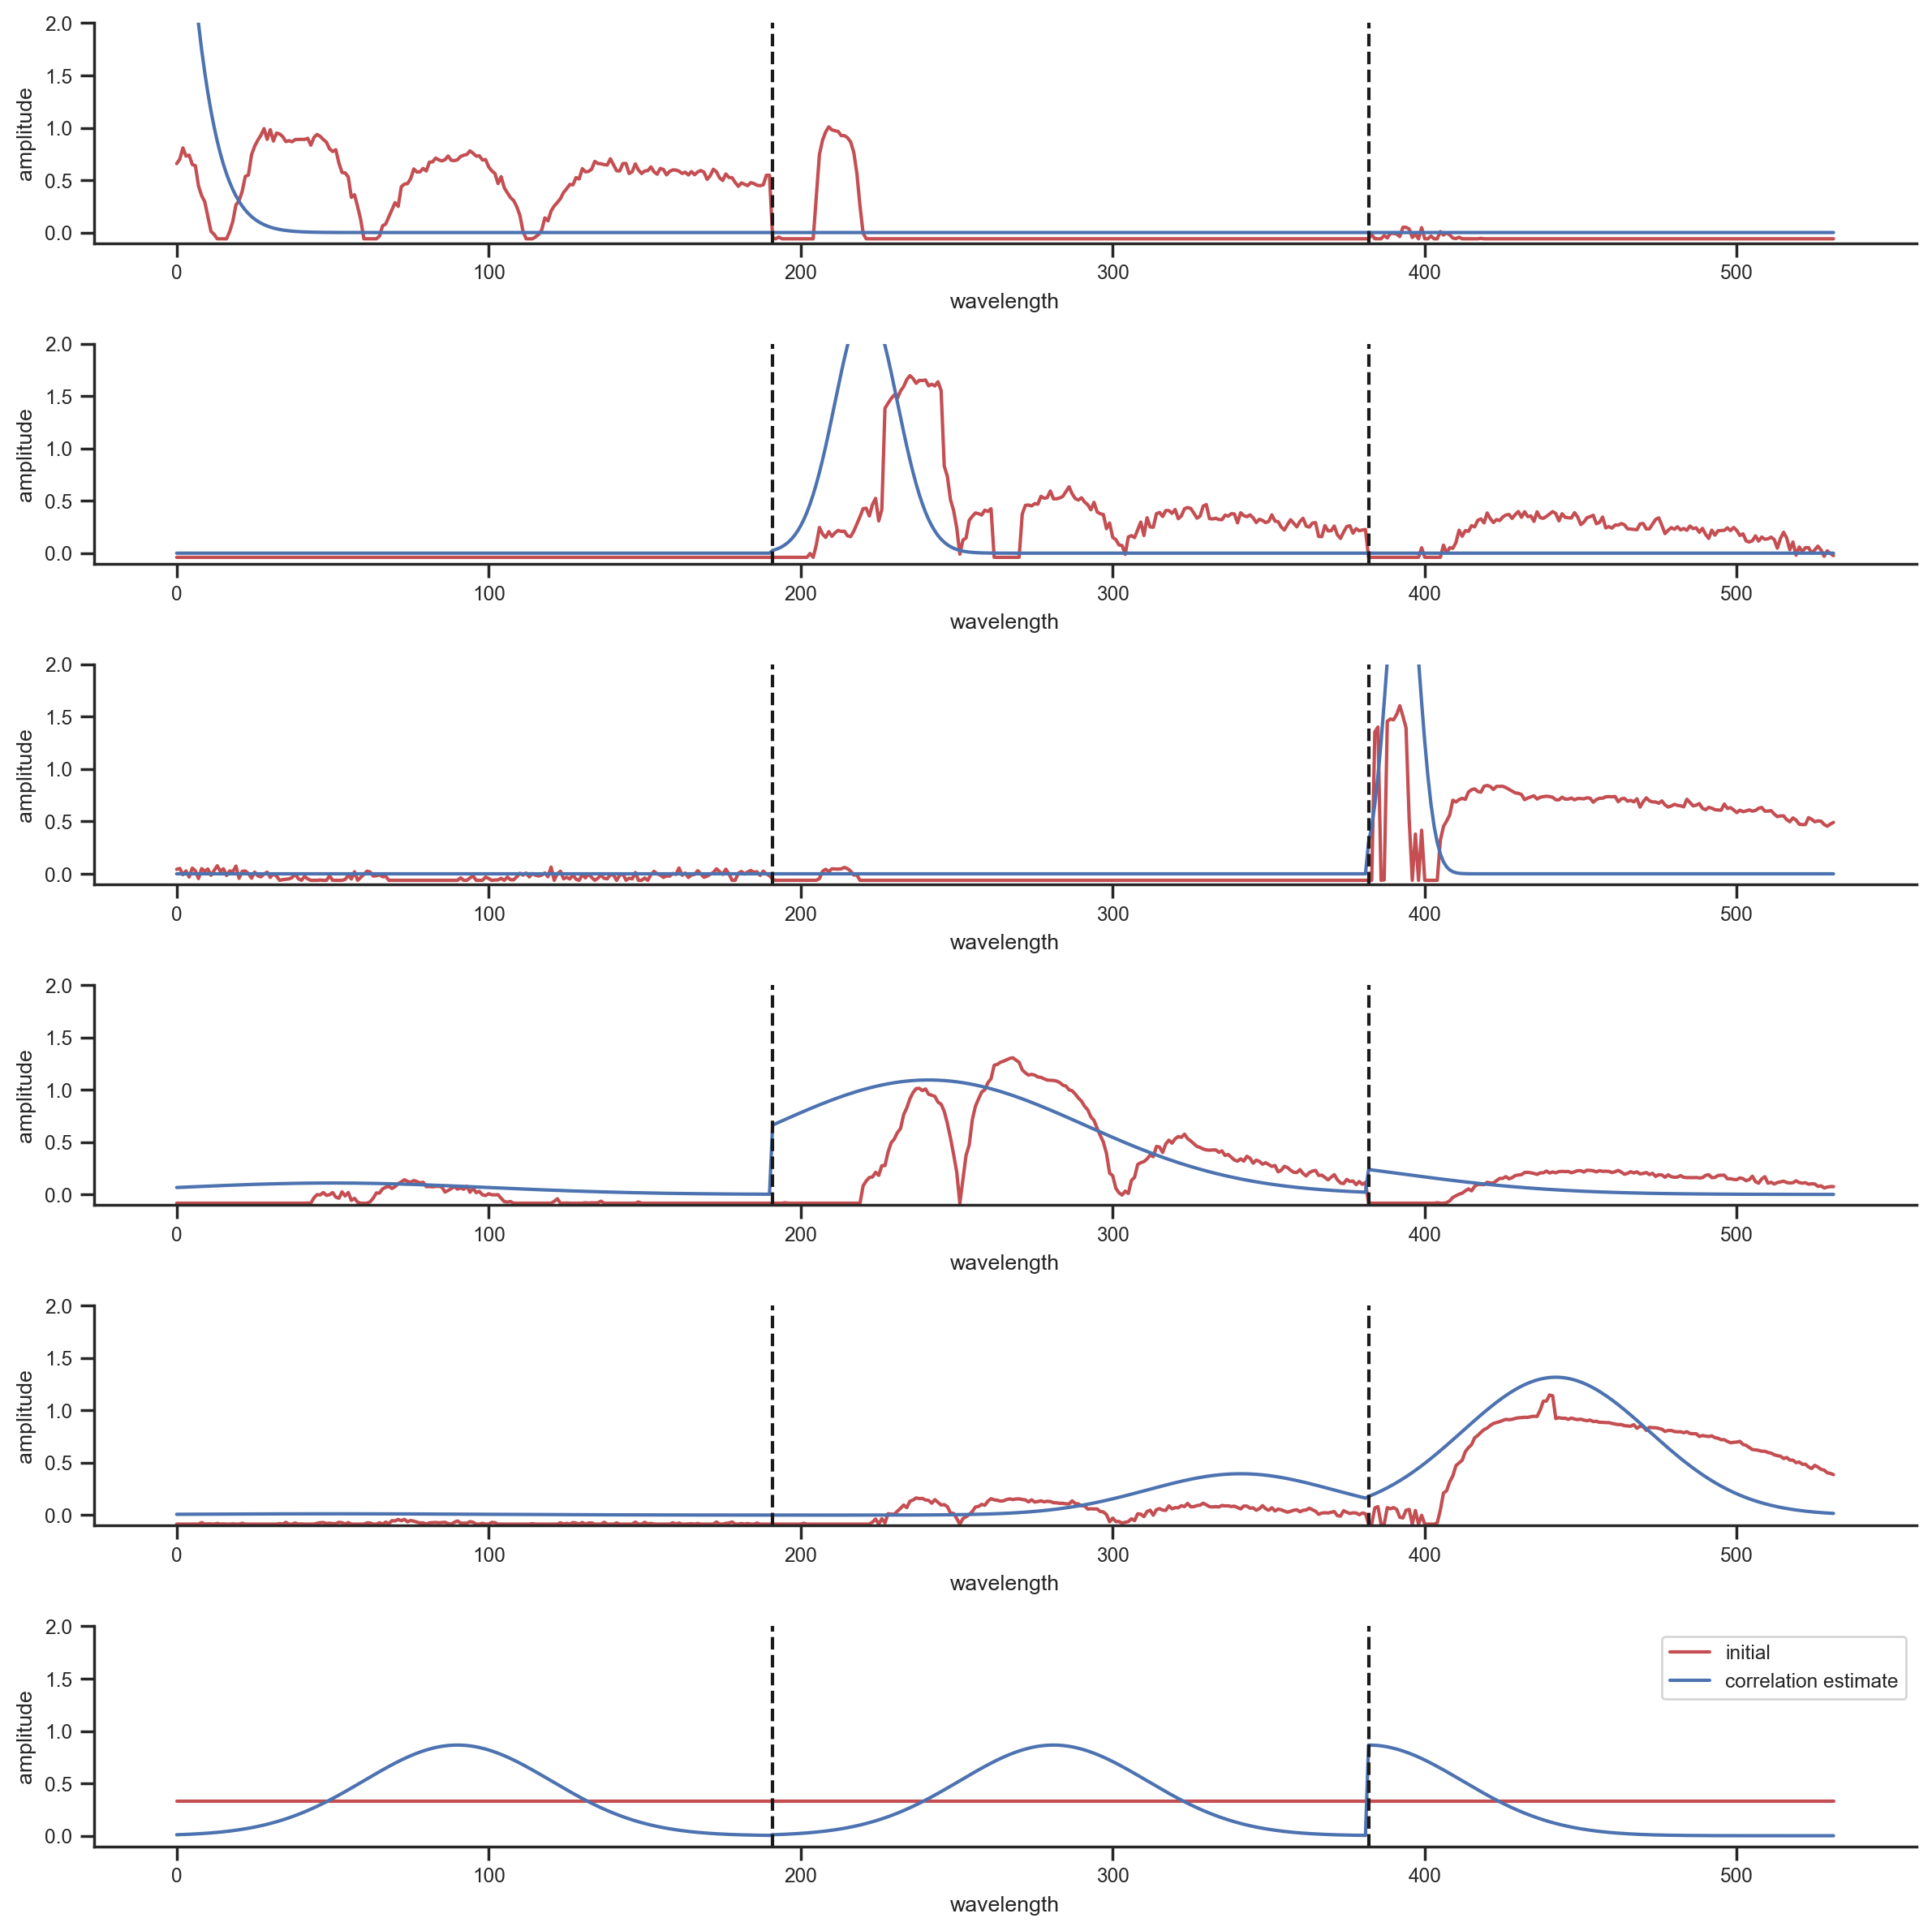

In [17]:
A_1 = set_norm(AA, axis=0, c=10.0)[0]
A_2 = set_norm(A_init_0, axis=0, c=10.0)[0]

f, ax = plt.subplots(6,1,figsize=(12,12))
for s in range(6):
    ax[s].plot(A_1[:,s].T-0.1, c='r', alpha = 1, label='initial')
    ax[s].plot(A_2[:,s].T, c='b', label='correlation estimate')
    ax[s].set(xlabel='wavelength', ylabel='amplitude', ylim=(-0.1, 2))
    ax[s].axvline(n_px_in_ch[0], color='k', linestyle='--')
    ax[s].axvline(n_px_in_ch[0]+n_px_in_ch[1], color='k', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

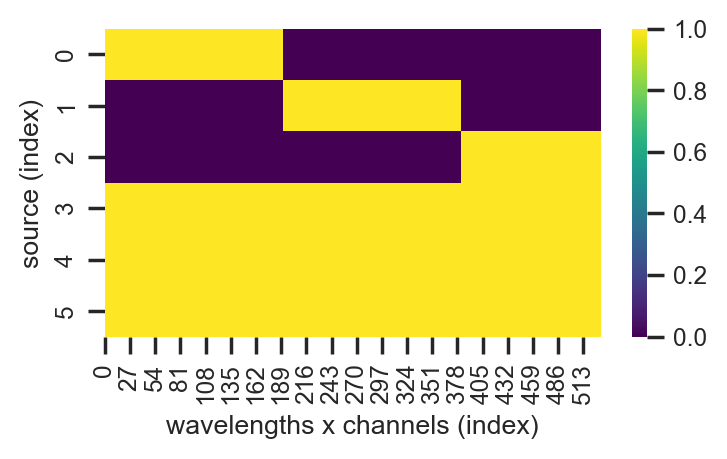

In [18]:
A_keep = np.zeros_like(AA).astype(bool)
A_keep[:n_px_in_ch[0], 0] = True  # laser in channel 0
A_keep[n_px_in_ch[0]:n_px_in_ch[0] + n_px_in_ch[1], 1] = True  # laser in channel 2
A_keep[n_px_in_ch[0]+n_px_in_ch[1]:, 2] = True  # laser in channel 4
A_keep[:, 3] = True  # indicator Ca
A_keep[:, 4] = True  # indicator Da
A_keep[:, 5] = True  # autofluorescence

f, ax = plt.subplots(figsize=(4, 2))
sns.heatmap(A_keep.T, cmap='viridis', ax=ax)
ax.set(xlabel='wavelengths x channels (index)', ylabel='source (index)')
plt.show()

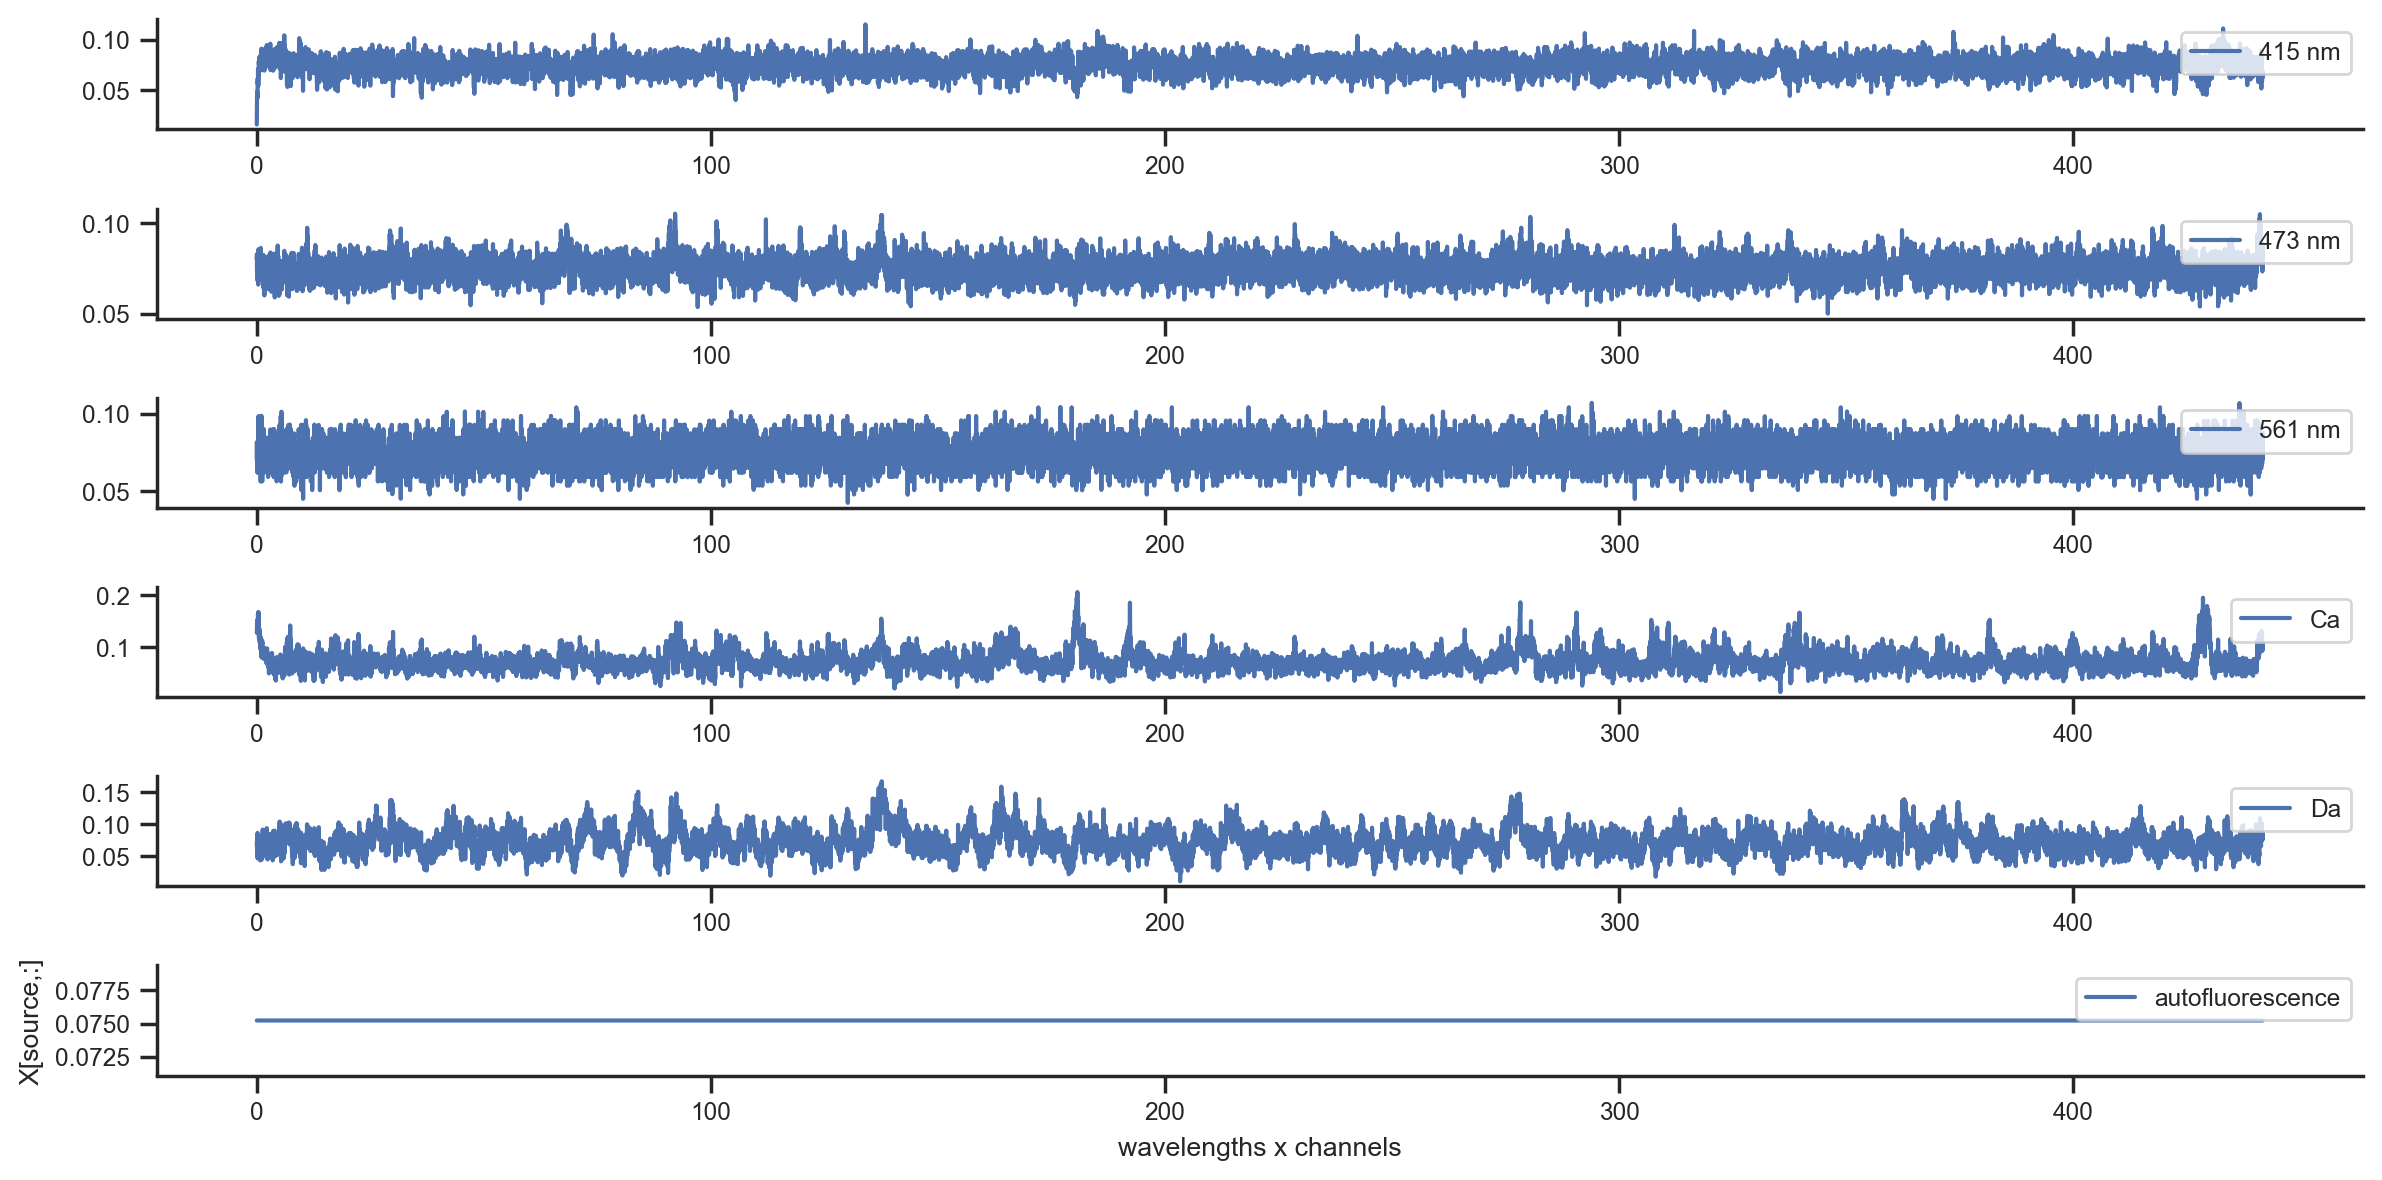

In [19]:
XX = np.ones((n_sources, YY.shape[1]))

for idx, src_id in enumerate(sel_sources):
    XX[idx,:] = sources[src_id]

XX[3,:] = sources[3]
XX[4,:] = sources[4]
XX = set_norm(XX, axis=1, c=10.0)[0]

f, ax = plt.subplots(6,1,figsize=(12,6))
ax[0].plot(t, XX[0,:].ravel(), label='415 nm')
ax[1].plot(t, XX[1,:].ravel(), label='473 nm')
ax[2].plot(t, XX[2,:].ravel(), label='561 nm')
ax[3].plot(t, XX[3,:].ravel(), label='Ca')
ax[4].plot(t, XX[4,:].ravel(), label='Da')
ax[5].plot(t, XX[5,:].ravel(), label='autofluorescence')
ax[5].set(xlabel='wavelengths x channels', ylabel='X[source,:]')

#show legend for all subplots
for i in range(6):
    ax[i].legend(bbox_to_anchor=(1.00, 1.00), loc='upper right')

plt.tight_layout()
plt.show()

In [20]:
X_init_0 = 1.0+0.1*np.random.randn(XX.shape[0], XX.shape[1])
X_init_0[X_init_0<1e-2] = 1e-2
X_init_0 = set_norm(X_init_0, axis=1, c=1.0)[0]

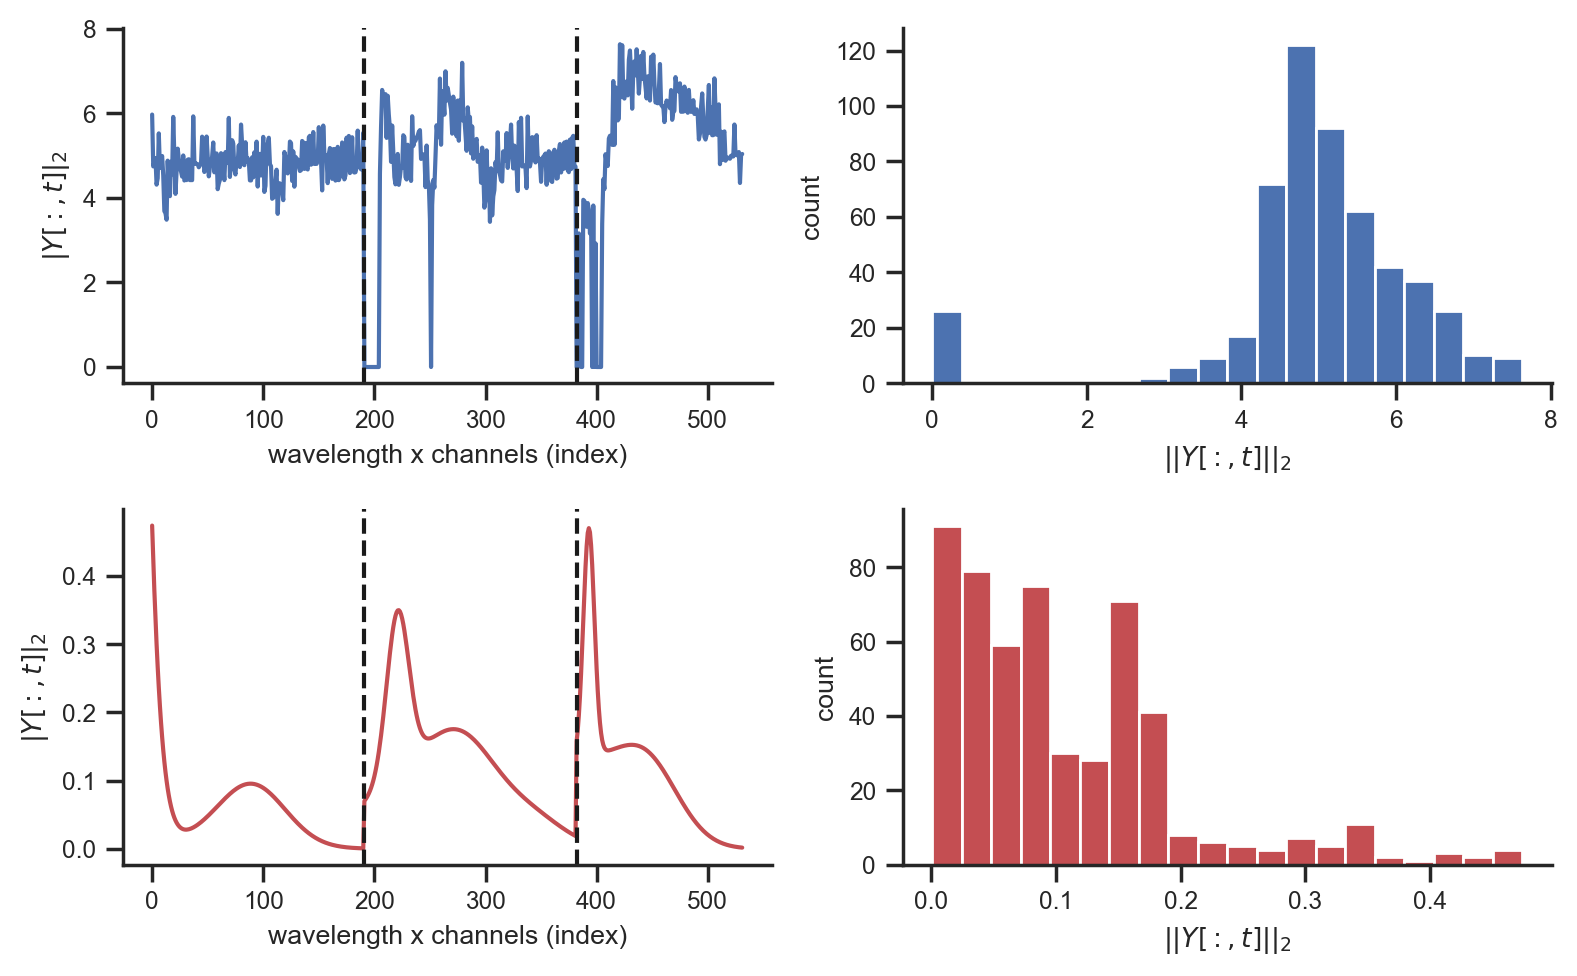

data median norm = 4.99 
 init median norm = 0.08
set norm = 7.665


In [21]:
f, ax = plt.subplots(2,2,figsize=(8,5))

norm_Y = np.linalg.norm(YY, ord=2, axis=1)
ax[0,0].plot(norm_Y)
ax[0,0].set(xlabel='wavelength x channels (index)', ylabel=r'$|Y[:,t]|_2$')
ax[0,0].axvline(n_px_in_ch[0], color='k', linestyle='--')
ax[0,0].axvline(n_px_in_ch[0]+n_px_in_ch[1], color='k', linestyle='--')

ax[0,1].hist(norm_Y, bins=20)
ax[0,1].set(xlabel=r'$||Y[:,t]||_2$', ylabel='count')

Y_init_0 = set_norm(A_init_0,axis=0,c=1.0)[0] @ set_norm(X_init_0,axis=1,c=1.0)[0]

norm_Y_init_0 = np.linalg.norm(Y_init_0, ord=2, axis=1)
ax[1,0].plot(norm_Y_init_0, c='r')
ax[1,0].set(xlabel='wavelength x channels (index)', ylabel=r'$|Y[:,t]|_2$')
ax[1,0].axvline(n_px_in_ch[0], color='k', linestyle='--')
ax[1,0].axvline(n_px_in_ch[0]+n_px_in_ch[1], color='k', linestyle='--')

ax[1,1].hist(norm_Y_init_0, bins=20, color='r')
ax[1,1].set(xlabel=r'$||Y[:,t]||_2$', ylabel='count')

plt.tight_layout()
plt.show()

print(f'data median norm = {np.median(norm_Y):0.2f} \n init median norm = {np.median(norm_Y_init_0):0.2f}')
print(f'set norm = {np.sqrt(np.median(norm_Y)/ np.median(norm_Y_init_0)):0.3f}')
# top row is for input data
# bottom row is for the initialization.
# We'll set the initialization close to the 

In [22]:
import pickle
print(f'YY: {YY.shape}')
print(f'AA: {AA.shape}')
print(f'XX: {XX.shape}')

dat = dict(Y=YY,
           A_corr=set_norm(AA, axis=0, c=1.0)[0].copy(),
           X_roi=set_norm(XX, axis=1, c=1.0)[0].copy(),
           A_keep=A_keep.copy(),
           X_keep=None,
           A_init_0=set_norm(A_init_0, axis=0, c=6.5)[0].copy(),
           X_init_0=set_norm(X_init_0, axis=1, c=6.5)[0].copy(),
           l_channels=l_channels,
           n_px_in_ch=n_px_in_ch,
           l=l,
           t=t)

fname = paths['root'] / 'sims' / 'nmf_dual_indicator_test_data.pkl'
with open(fname, 'wb') as f:
    pickle.dump(dat, f)

YY: (532, 17666)
AA: (532, 6)
XX: (6, 17666)


In [23]:
def plot_components(dat, res):
    X_init = set_norm(dat['X_init_0'], axis=1, c=10.0)[0]
    X_aprx = set_norm(dat['X_roi'], axis=1, c=10.0)[0]
    X_fit = set_norm(res['X'], axis=1, c=10.0)[0]

    f, ax = plt.subplots(6,1,figsize=(12,12))
    for s in range(6):
        ax[s].plot(t, X_init[s,:]-0.1, c='k', alpha = 0.5, label='init')
        ax[s].plot(t, X_aprx[s,:], c='b', label='roi-based estimate')
        ax[s].plot(t, X_fit[s,:] + 0.1, c='r', label='fit')
        ax[s].set(xlabel='time', ylabel='df/f', xlim=[200,250])
    plt.legend()
    plt.tight_layout()
    plt.show()

    A_init = set_norm(dat['A_init_0'], axis=0, c=10.0)[0]
    A_aprx = set_norm(dat['A_corr'], axis=0, c=10.0)[0]
    A_fit = set_norm(res['A'], axis=0, c=10.0)[0]


    f, ax = plt.subplots(6,1,figsize=(12,12))
    for s in range(6):
        ax[s].plot(A_init[:,s].T-0.1, c='k', alpha = 0.5, label='init')
        ax[s].plot(A_aprx[:,s].T, c='b', label='correlation estimate')
        ax[s].plot(A_fit[:,s].T + 0.1, c='r', label='fit')
        ax[s].set(xlabel='wavelength', ylabel='amplitude', ylim=(-0.2, 2.2))
        ax[s].axvline(dat['n_px_in_ch'][0], color='k', linestyle='--')
        ax[s].axvline(dat['n_px_in_ch'][0]+dat['n_px_in_ch'][2], color='k', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

X and A are initialized, ignoring rank.


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


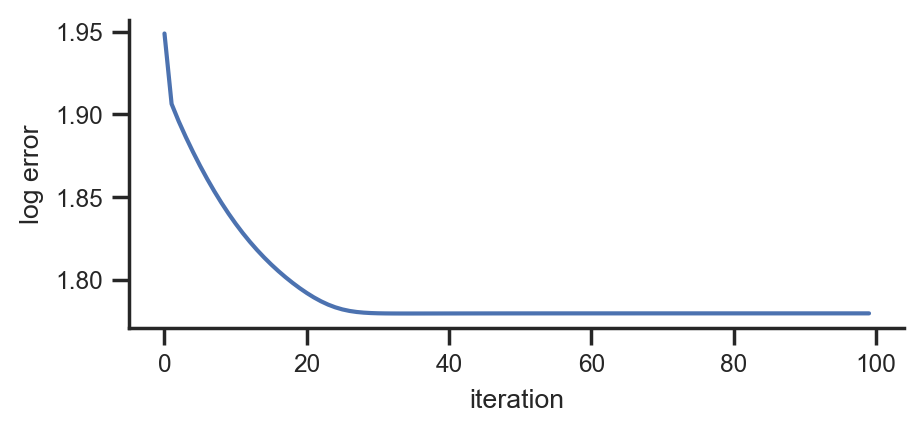

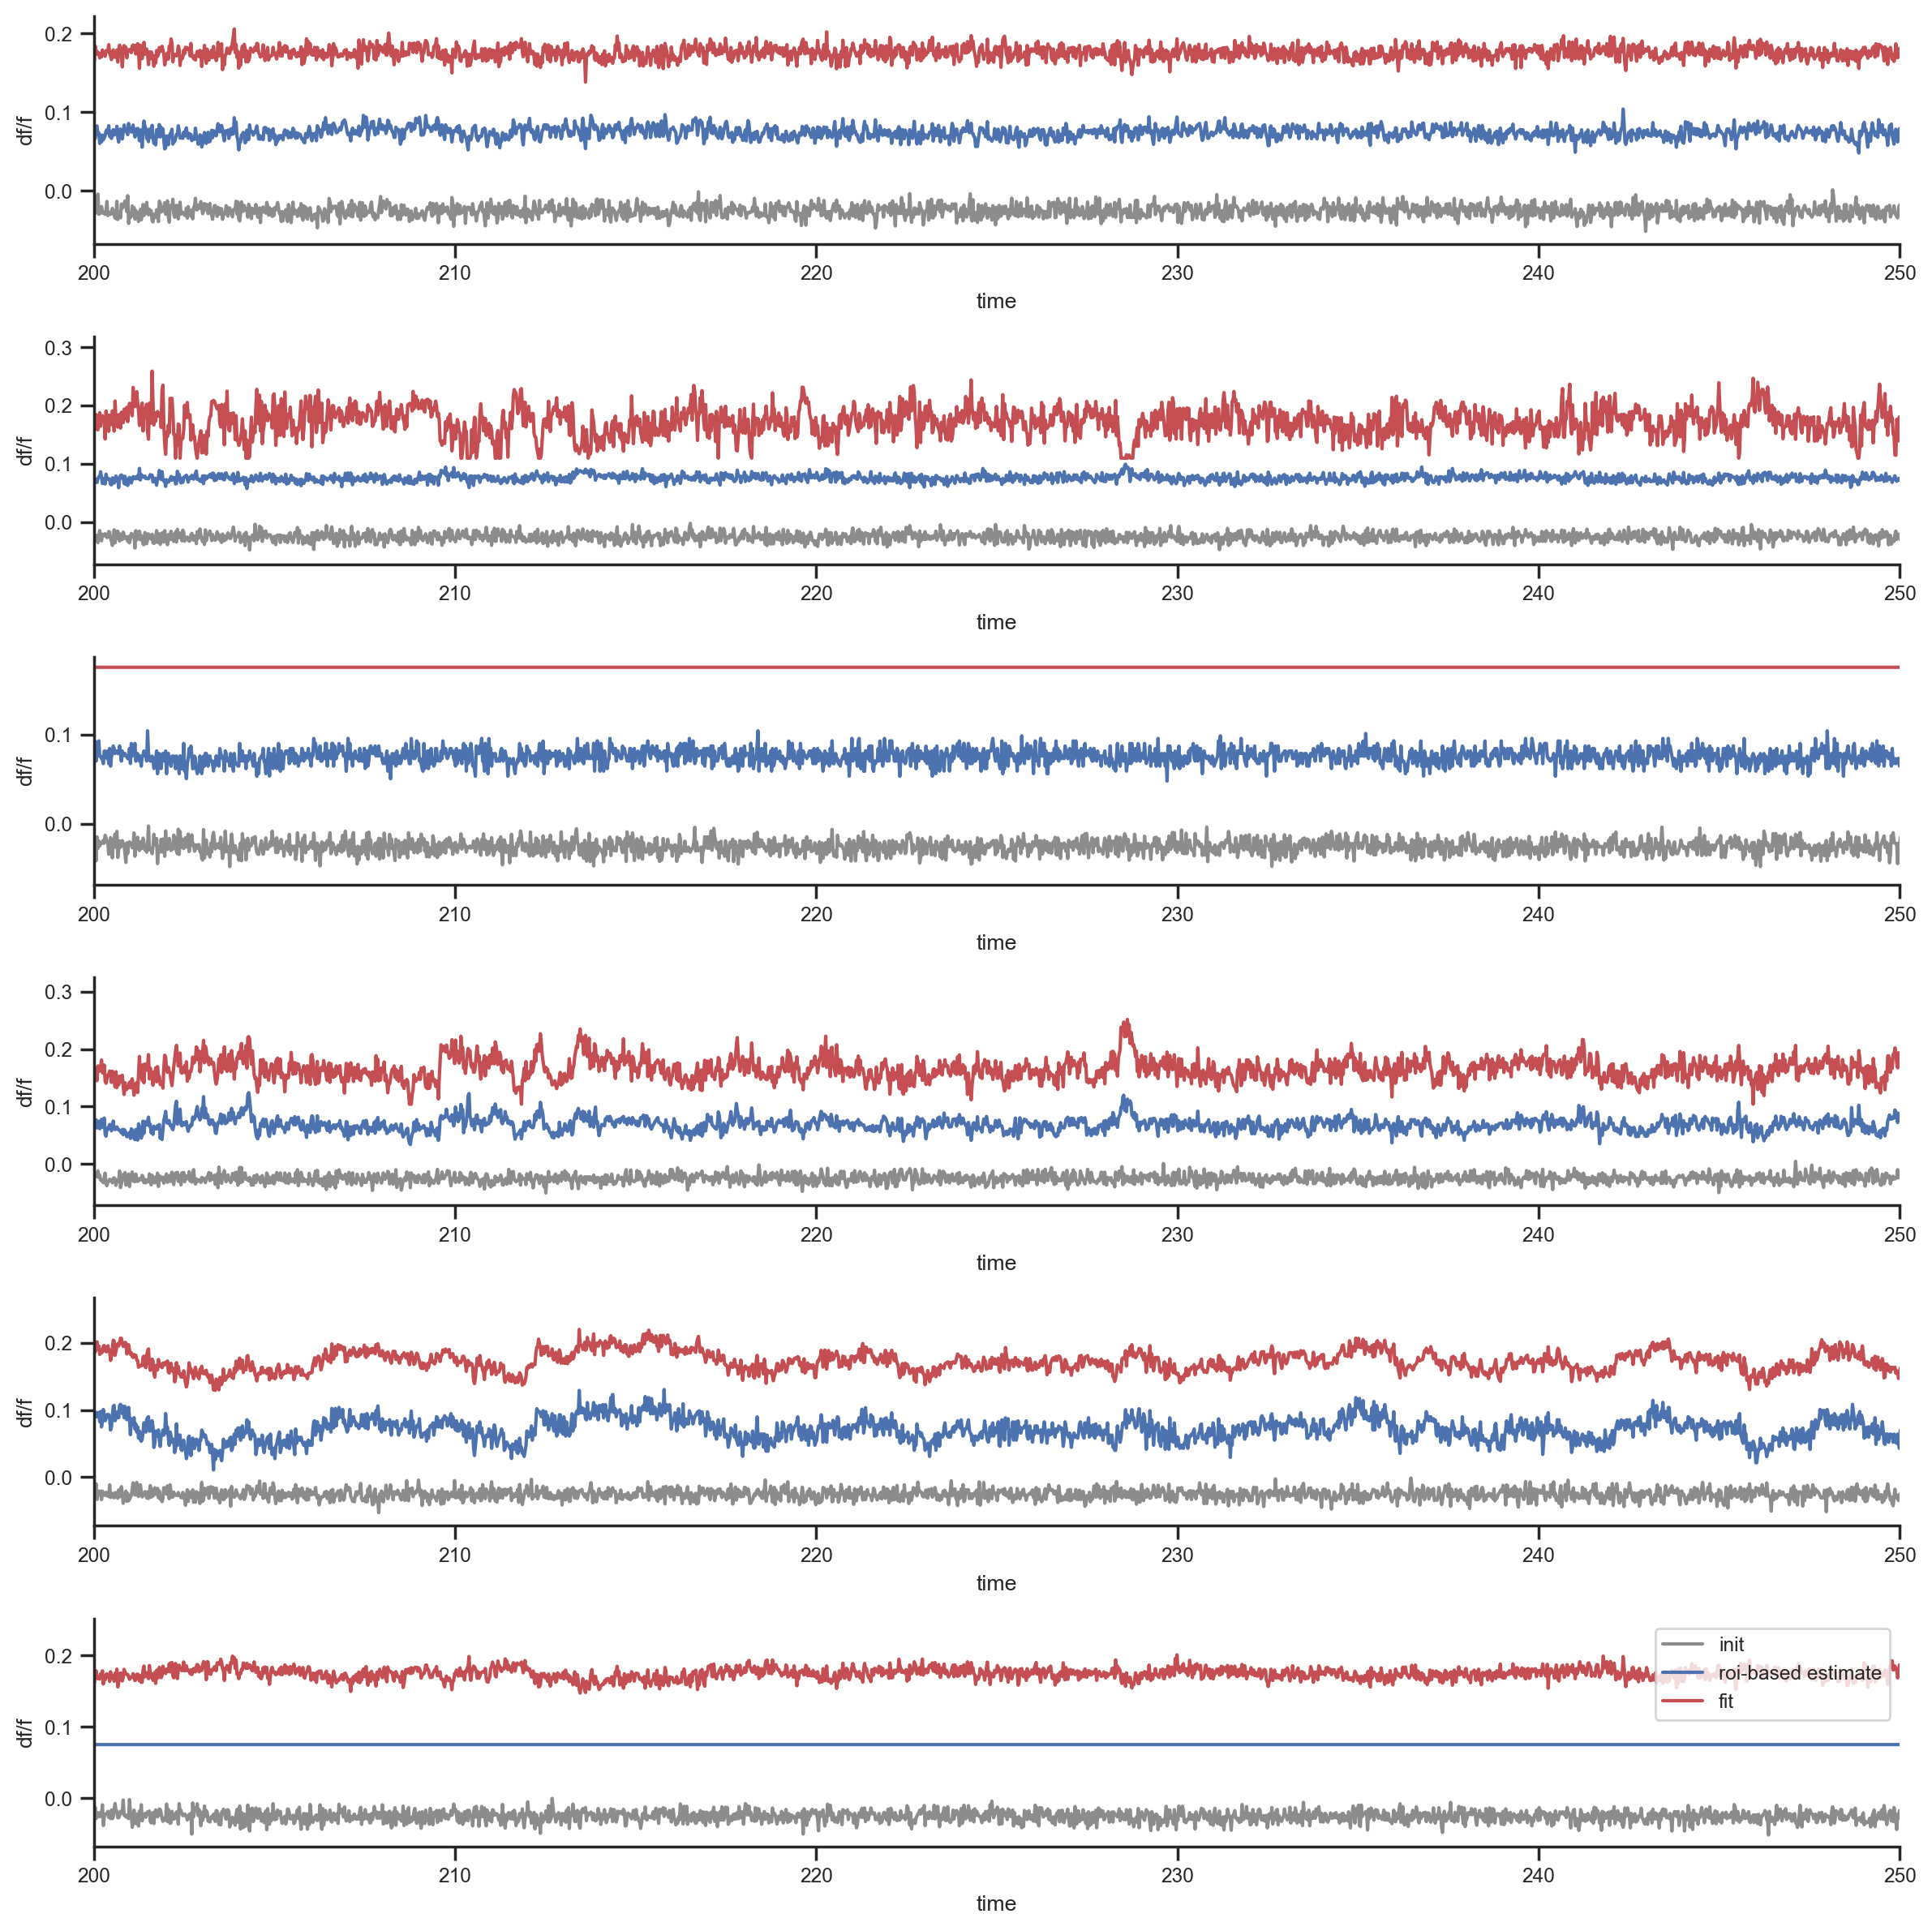

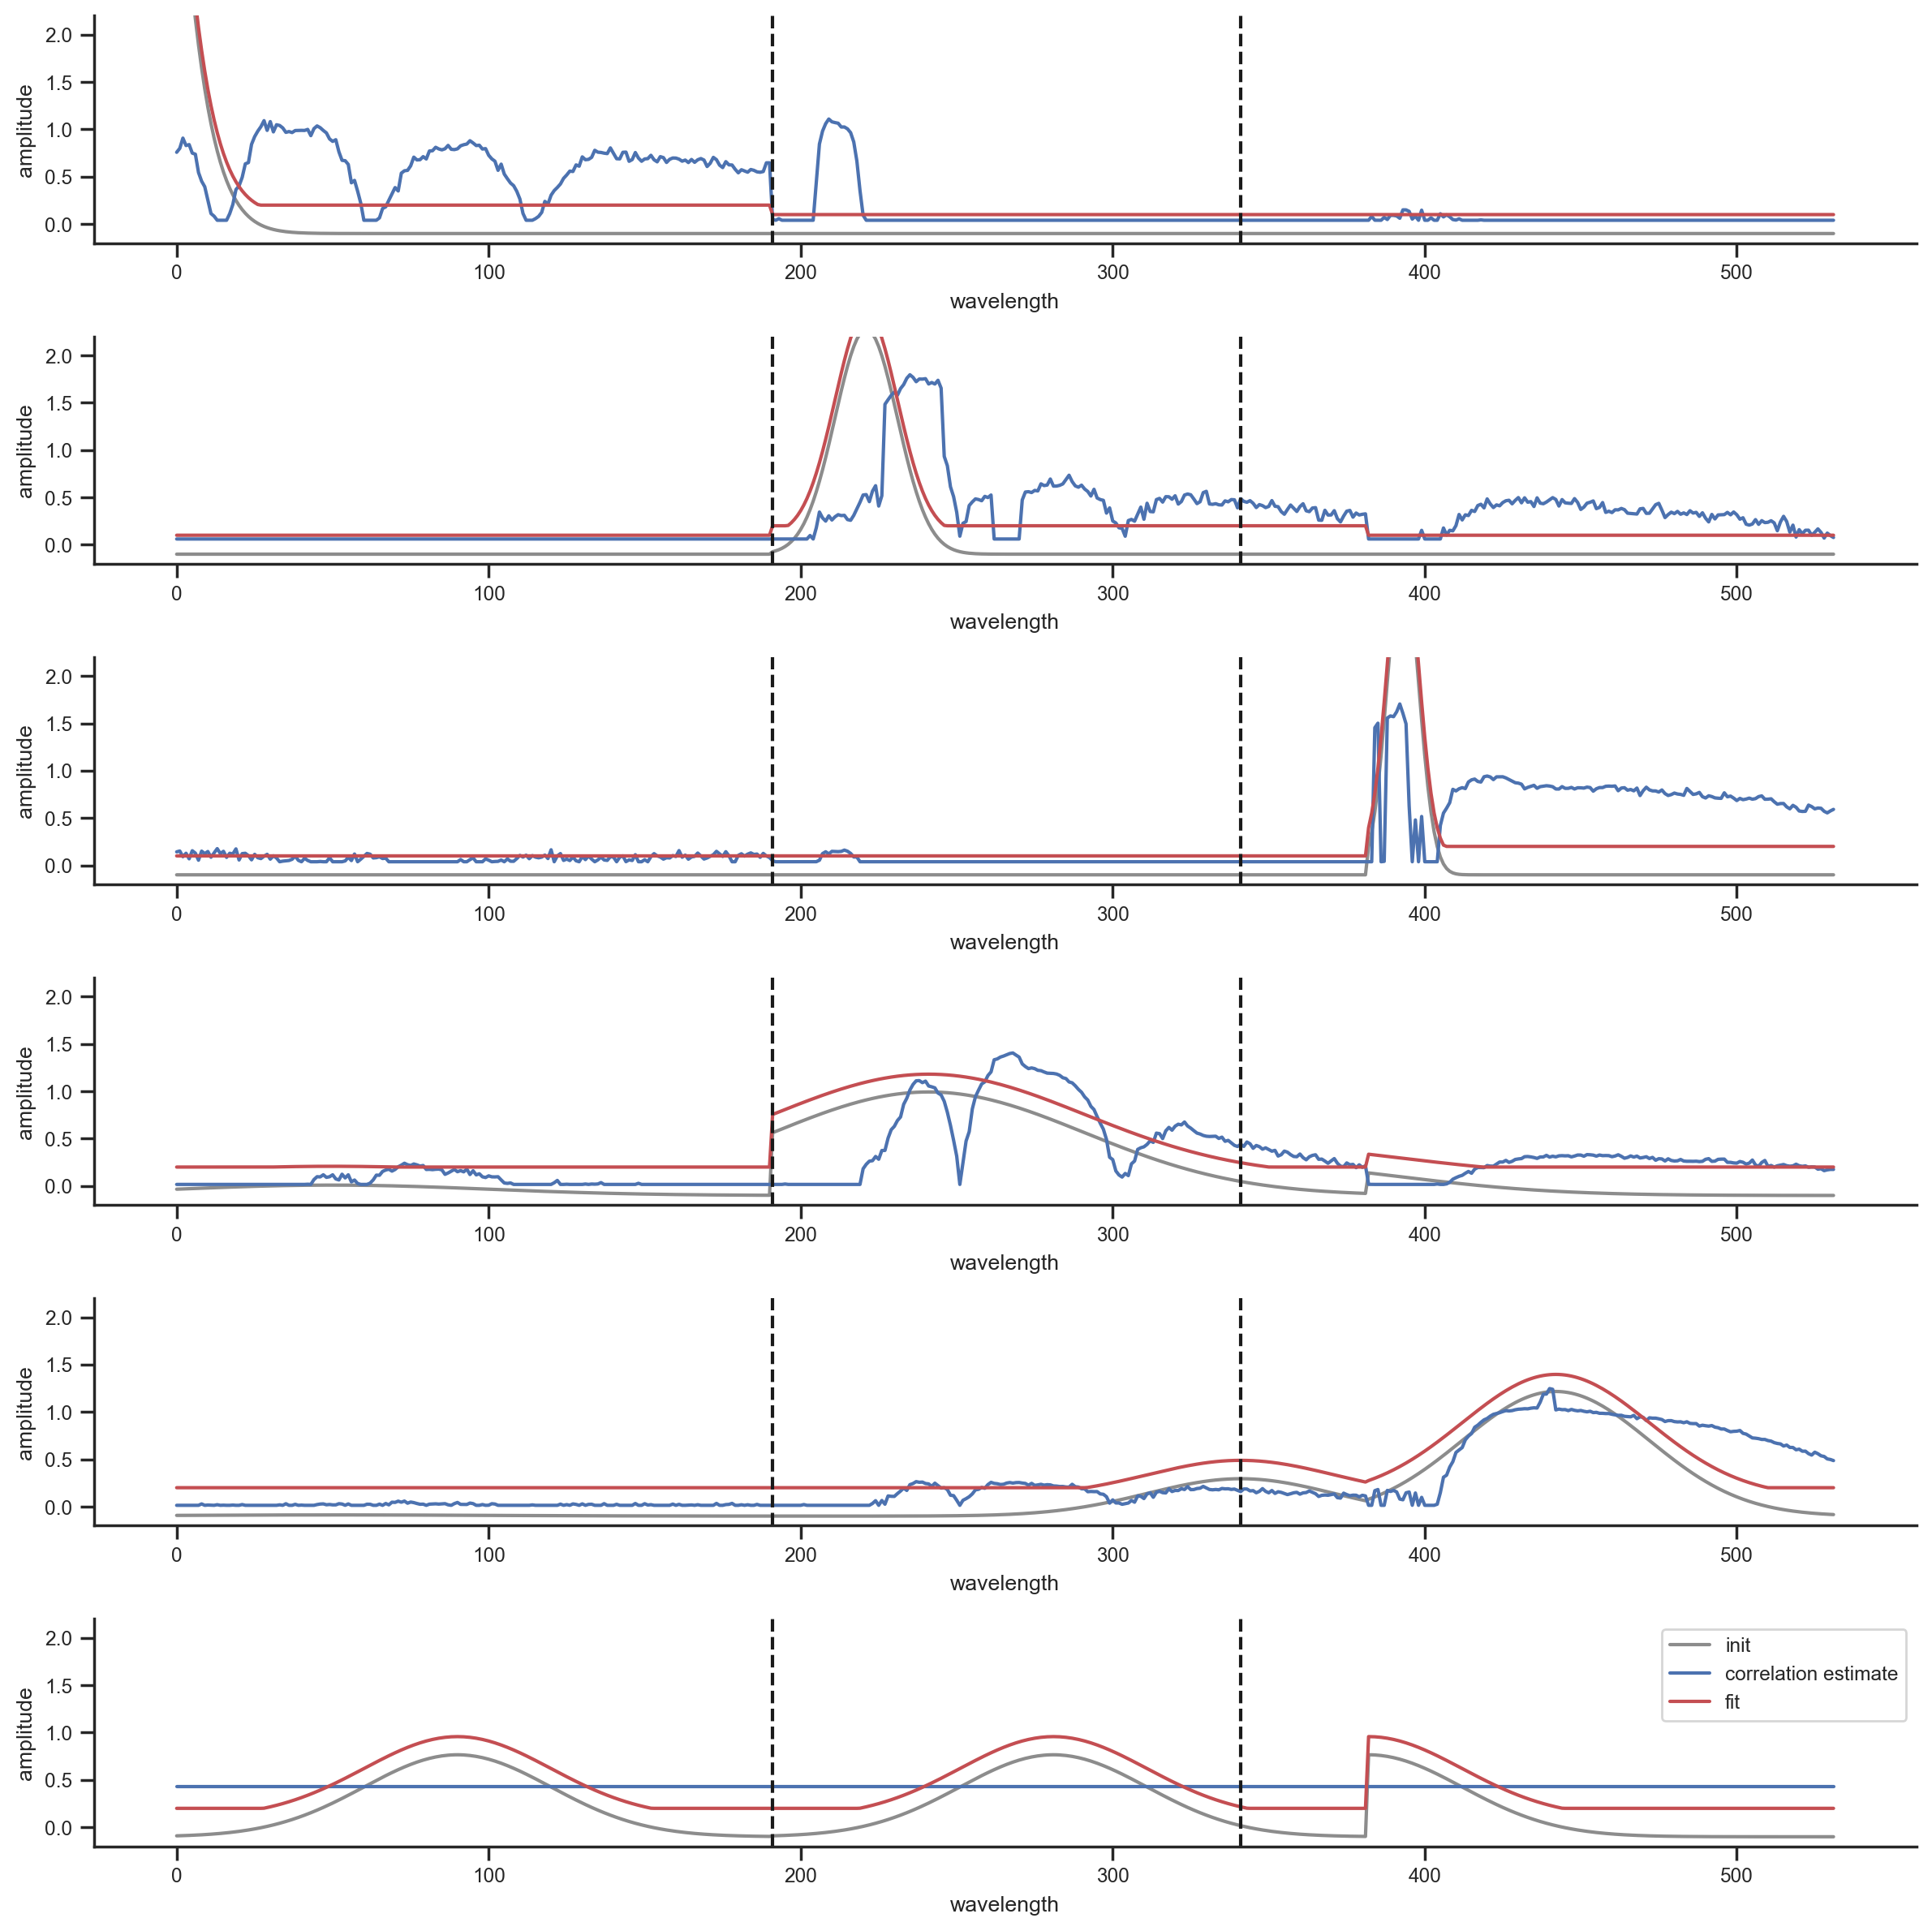

In [24]:
%autoreload 2
from sourcesep.models.nmf_variants import nmf_recipe_02, set_norm

A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=dat['A_init_0'].copy(), X=dat['X_init_0'].copy(), rank=5,
                                A_keep=dat['A_keep'].copy(), X_keep=None, grad_type=None,
                                step_size_A=1.0, step_size_X=1.0,
                                lam_sparsity_x=0.0, lam_2norm_x=0.00, lam_deviation_x=0.0,
                                fit_A=False, fit_X=True,
                                tol=1e-2, exit_tol=1e-7, max_iter=100)

res_warmup = {'A': A.copy(), 'X': X.copy(), 'err': err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_warmup['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

plot_components(dat, res_warmup)

X and A are initialized, ignoring rank.


100%|██████████| 400/400 [01:32<00:00,  4.34it/s]


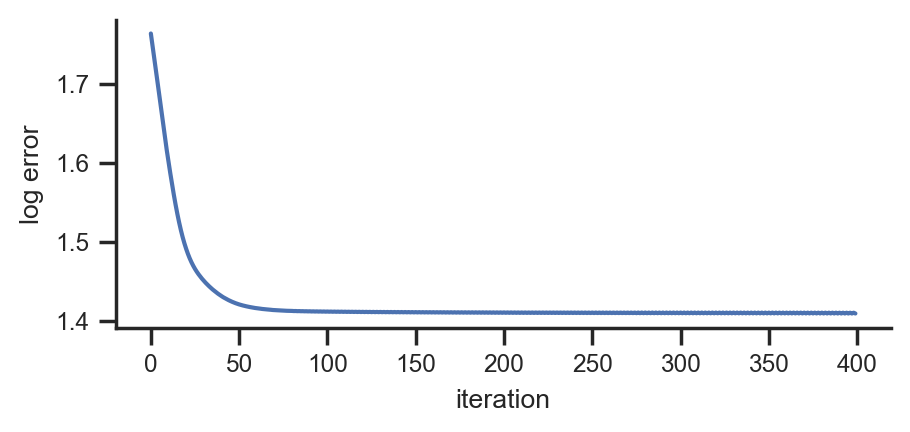

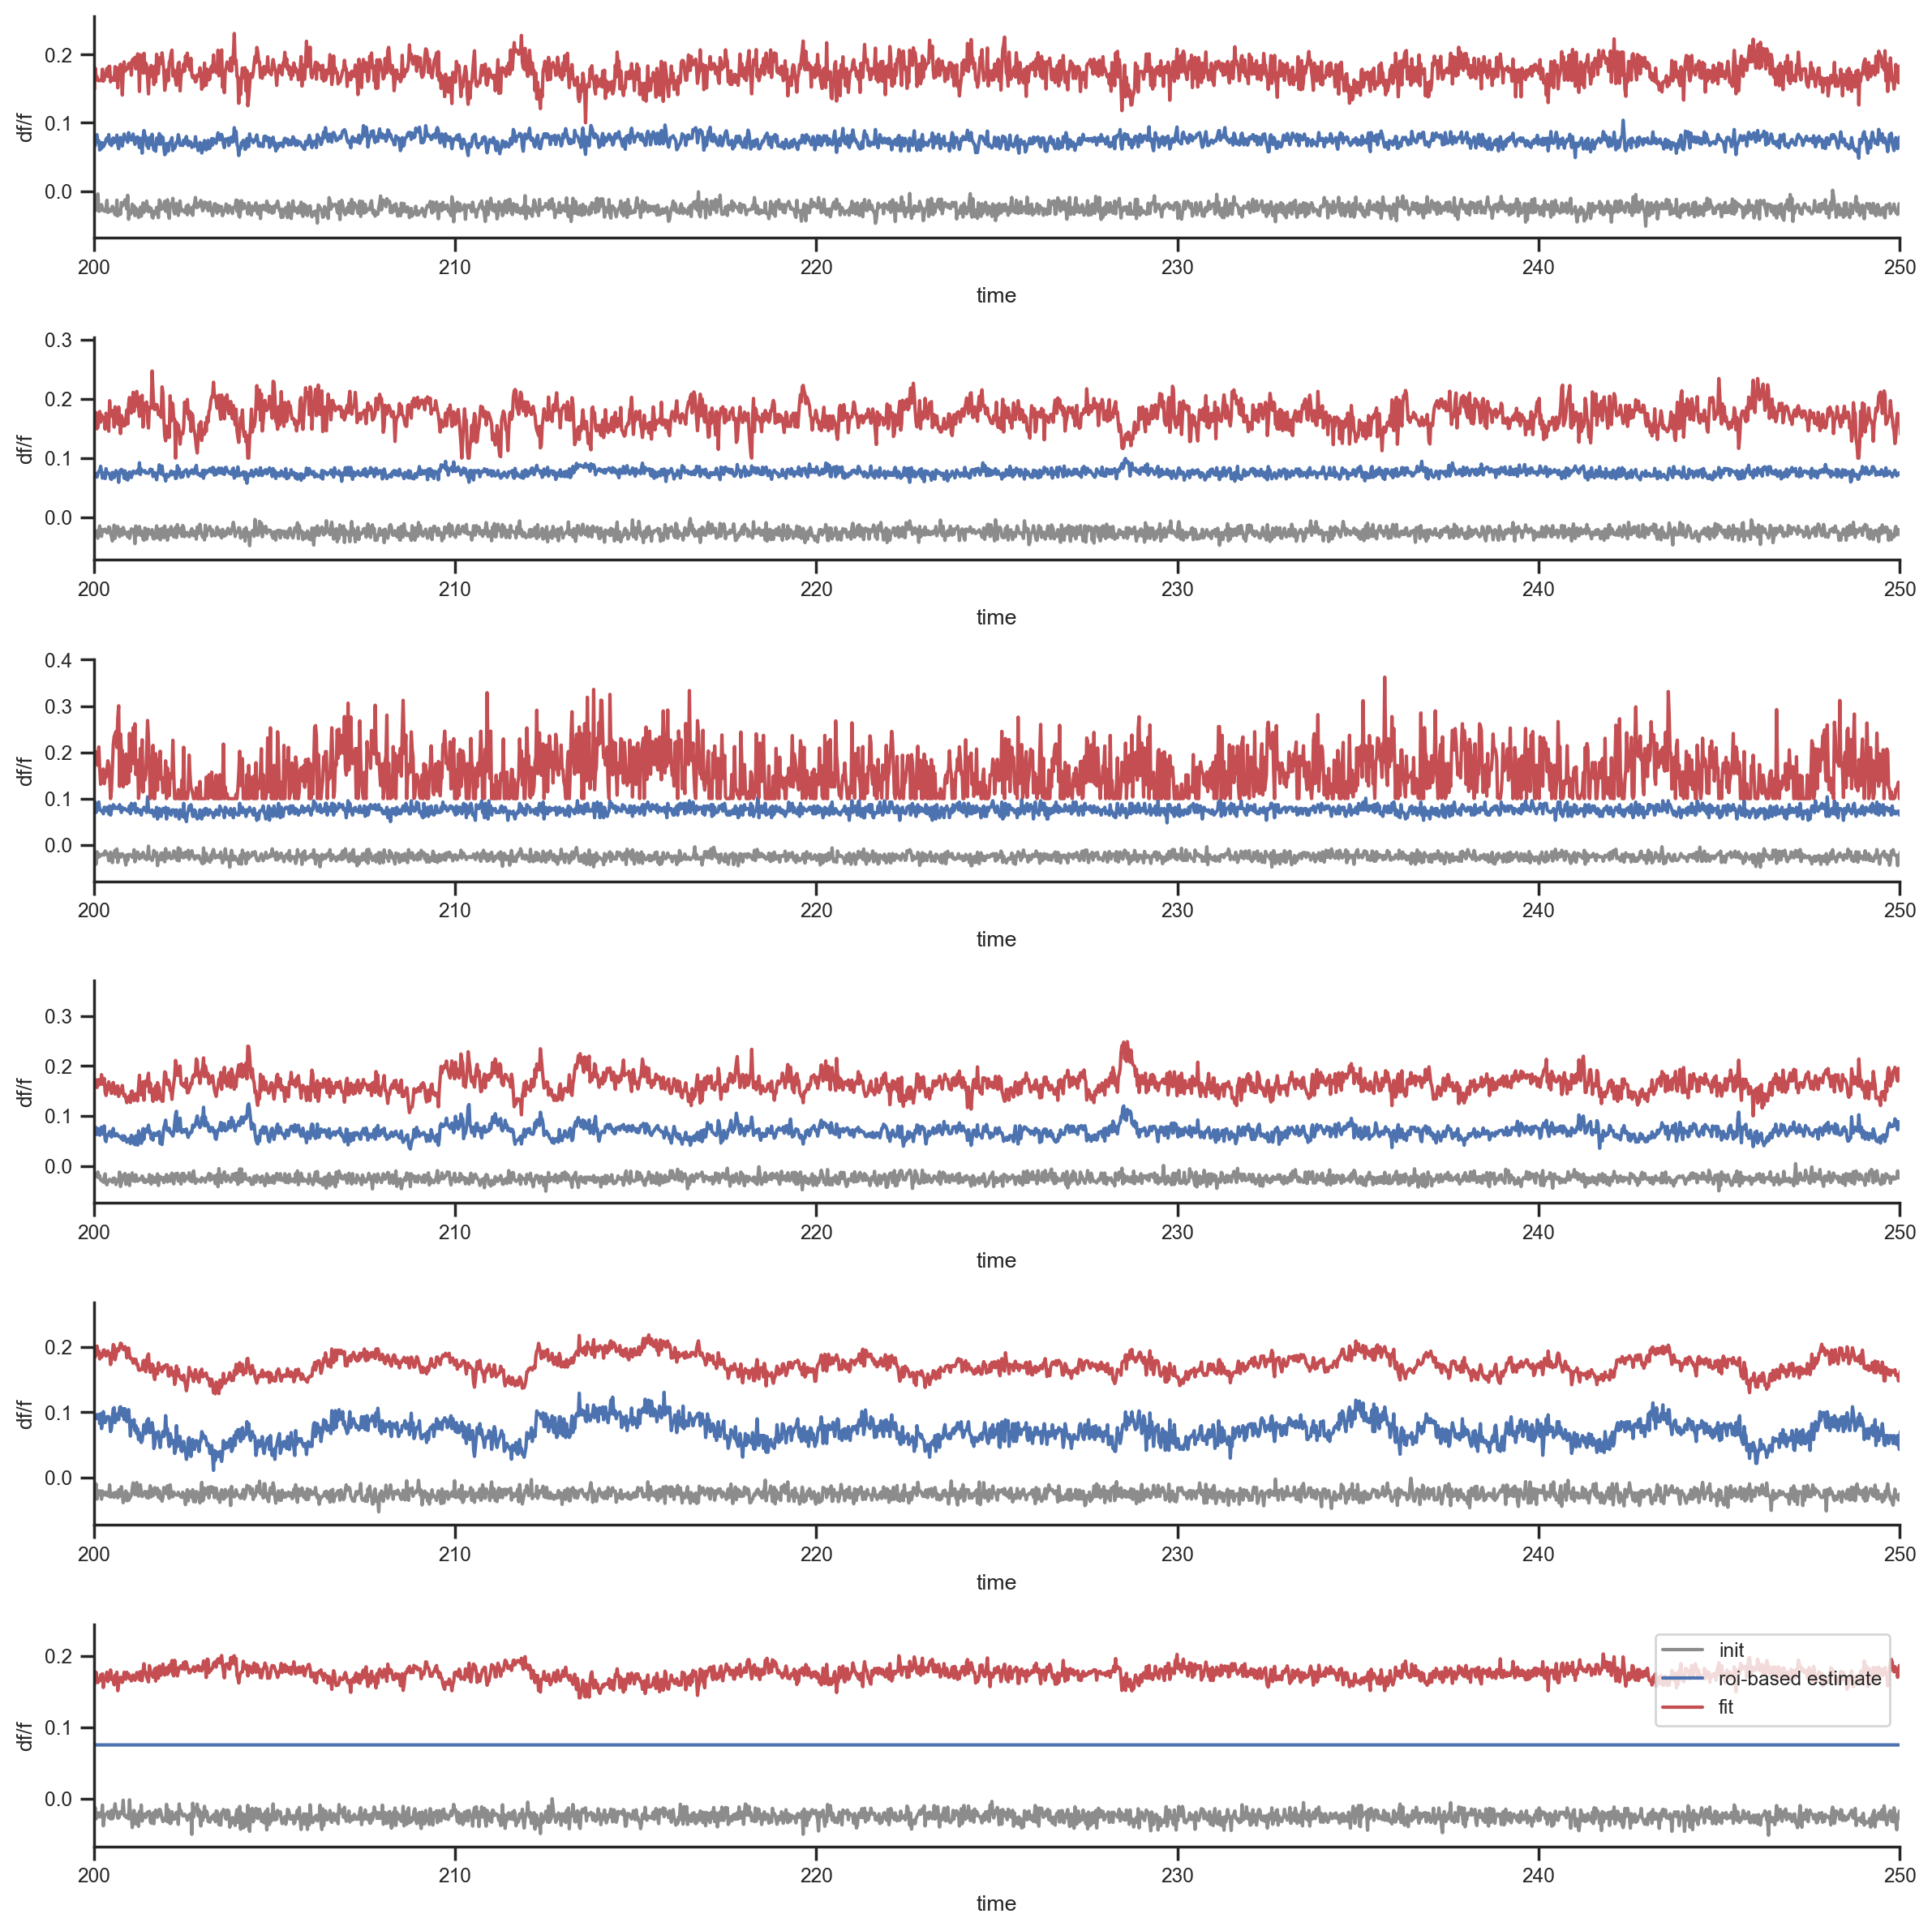

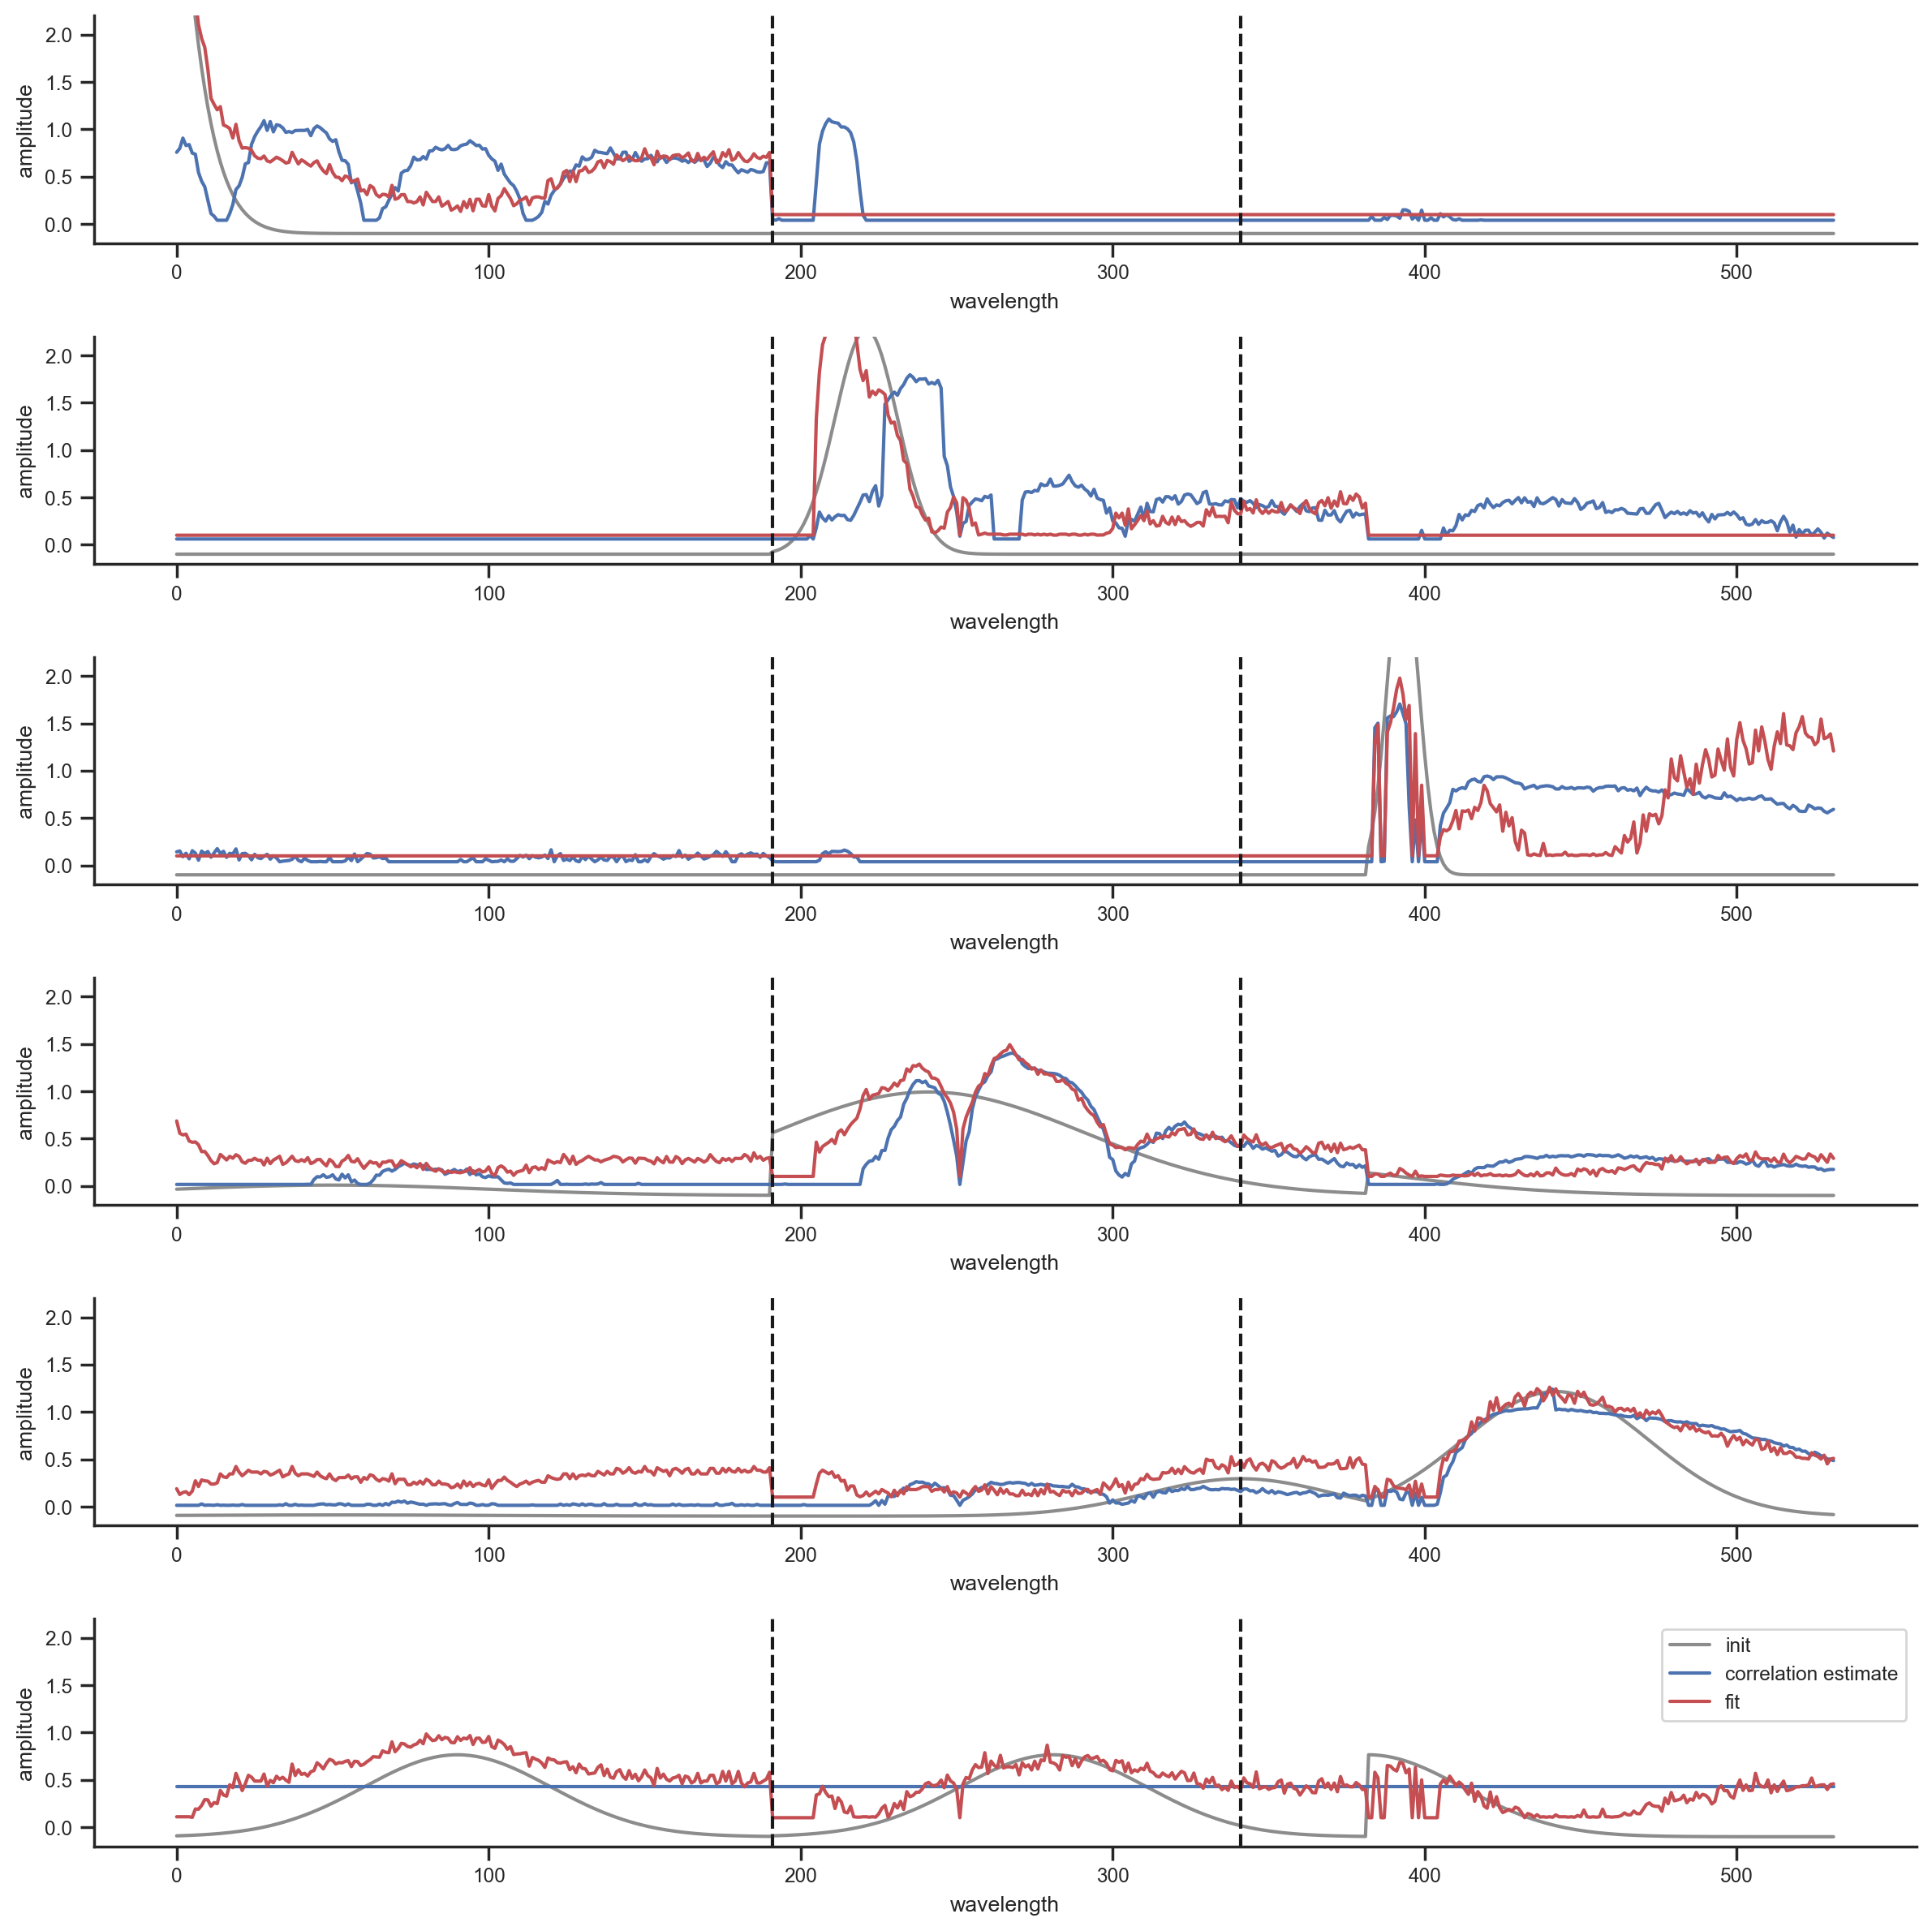

In [25]:
# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_warmup['A'].copy(), X=res_warmup['X'].copy(), rank=5,
                                A_keep=dat['A_keep'].copy(), X_keep=None, grad_type=None,
                                step_size_A=0.1, step_size_X=0.1,
                                lam_sparsity_x=0.0, lam_2norm_x=0.00, lam_deviation_x=0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-4, exit_tol=1e-7, max_iter=400)

res_fine_tune_0 = {'A': A.copy(), 'X': X.copy(), 'err': err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_0['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

plot_components(dat, res_fine_tune_0)

X and A are initialized, ignoring rank.


100%|██████████| 800/800 [03:04<00:00,  4.35it/s]


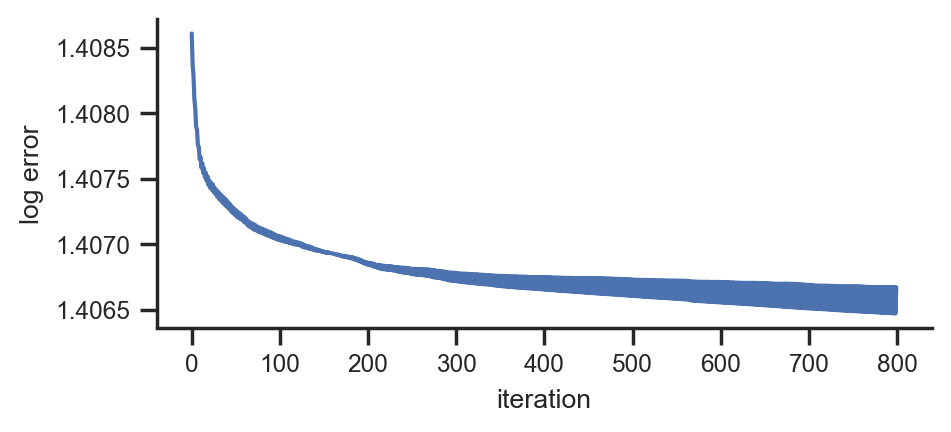

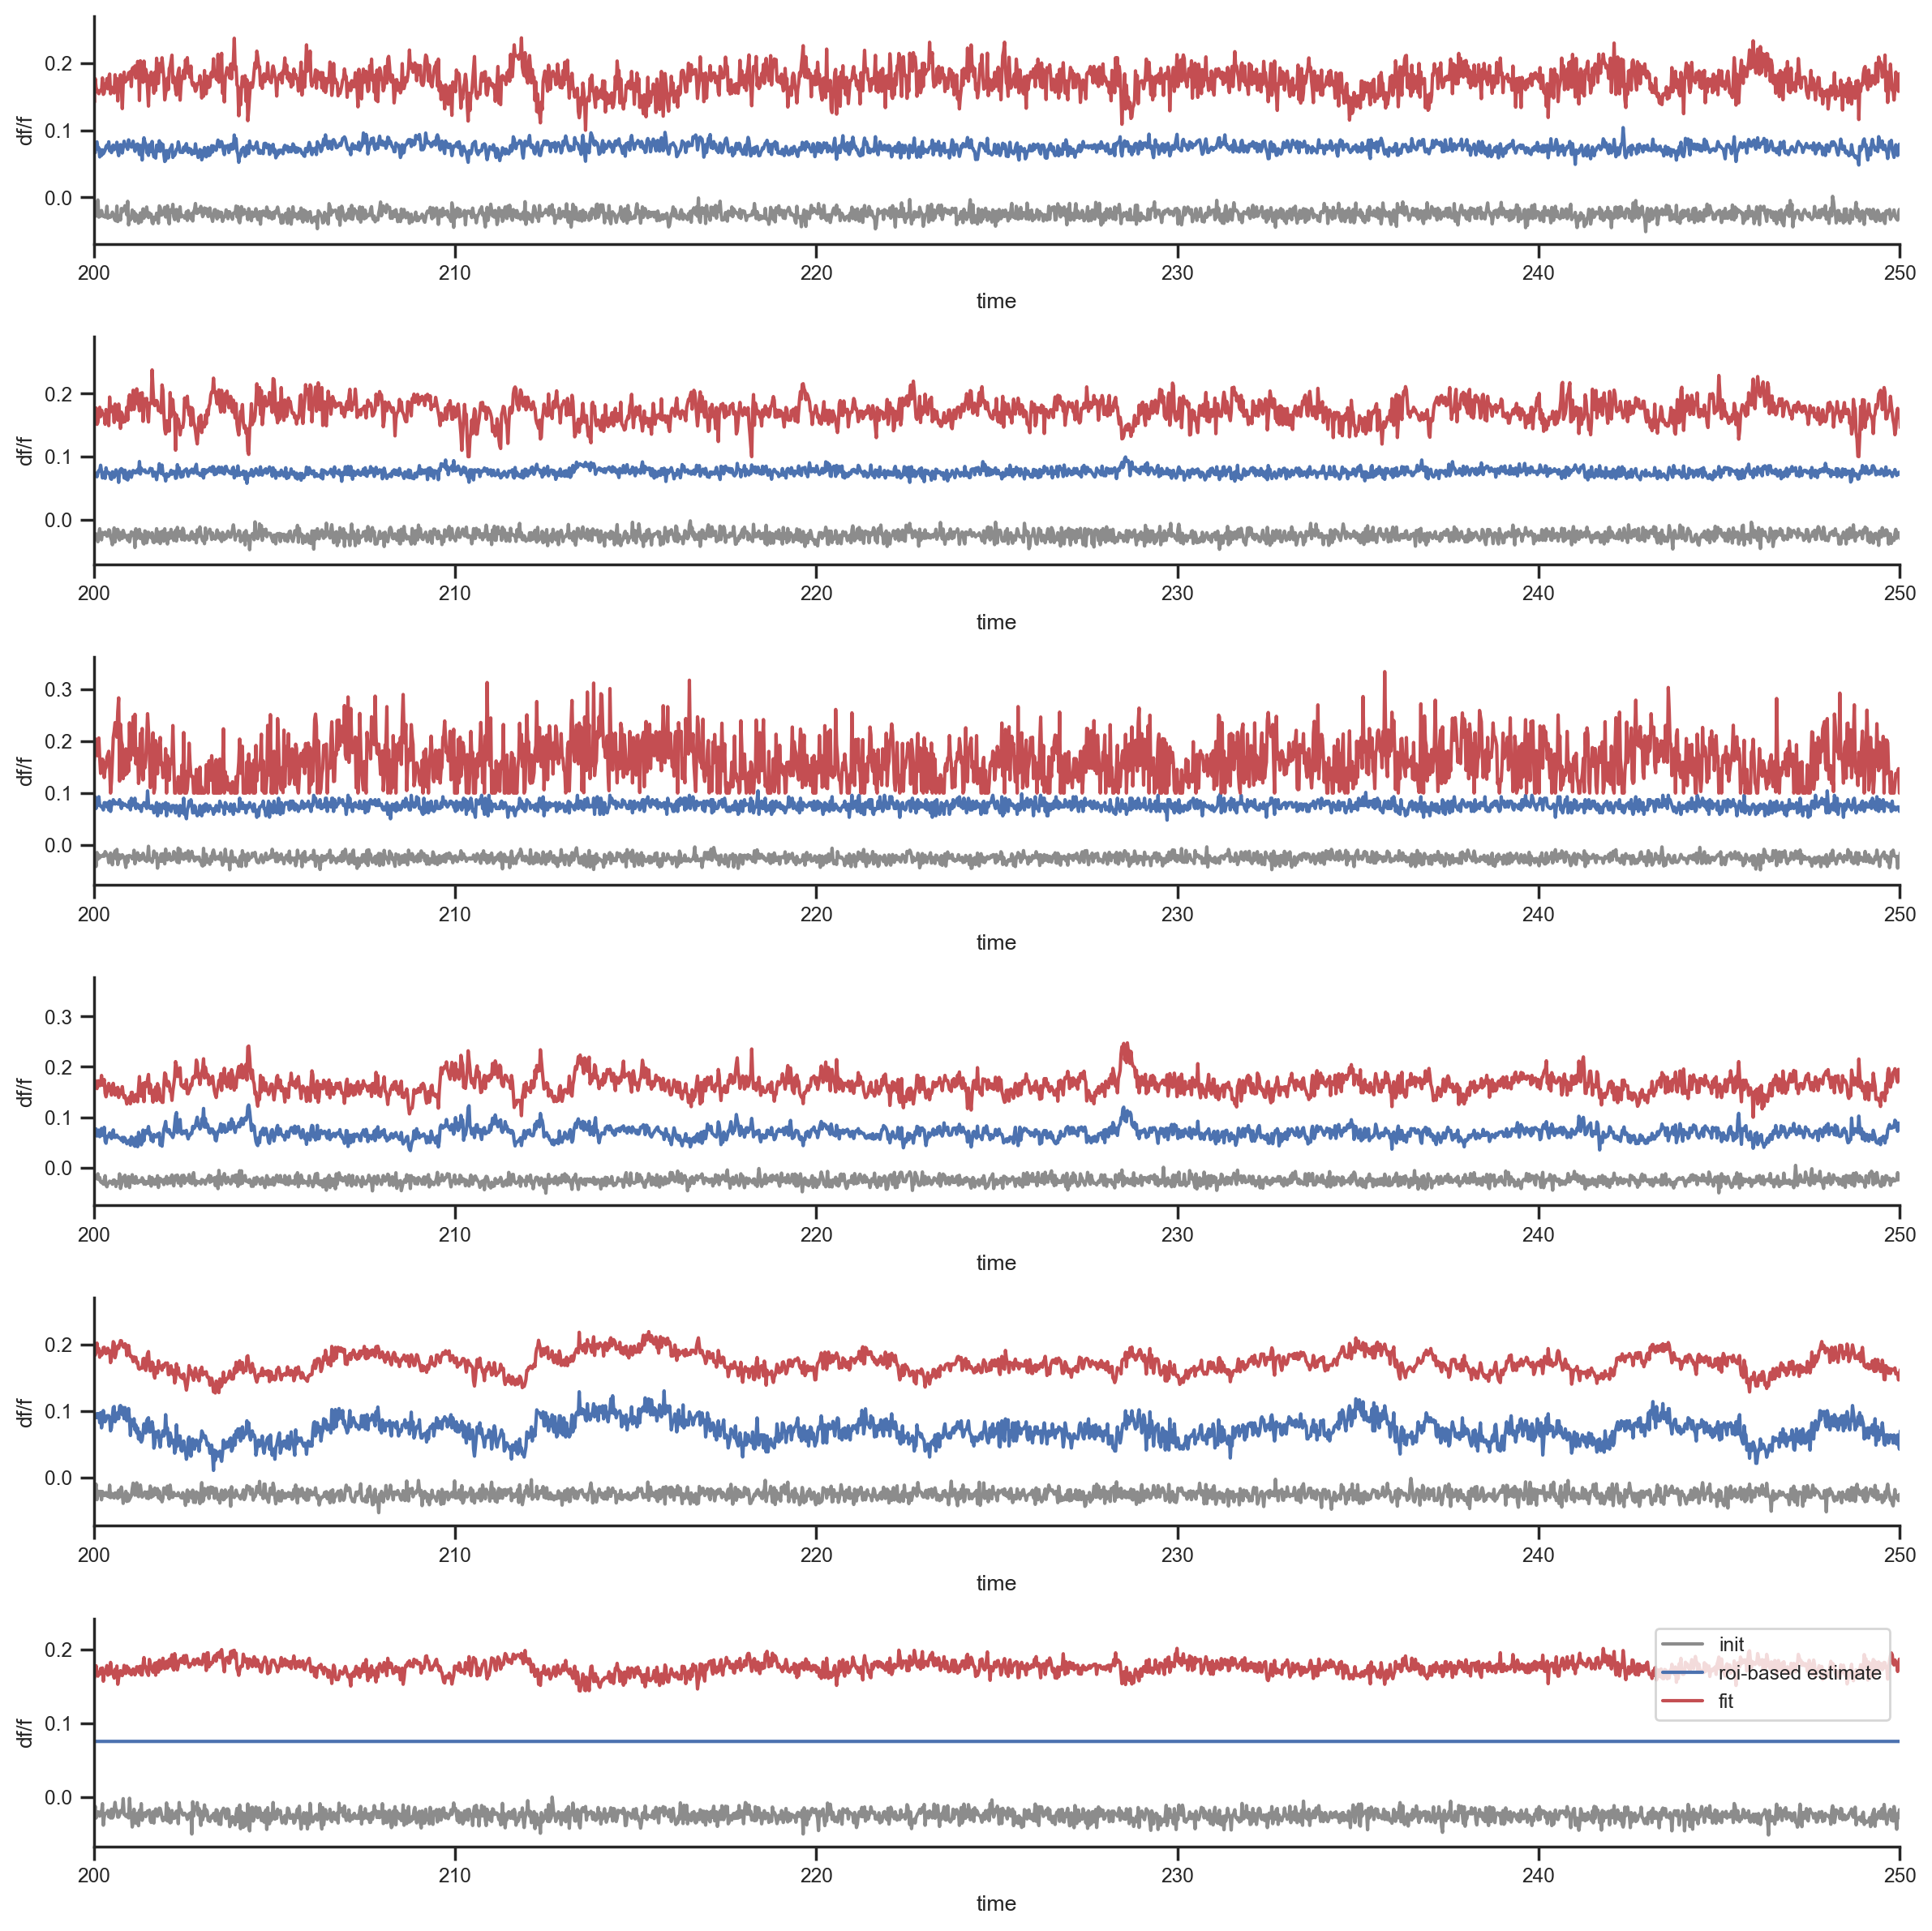

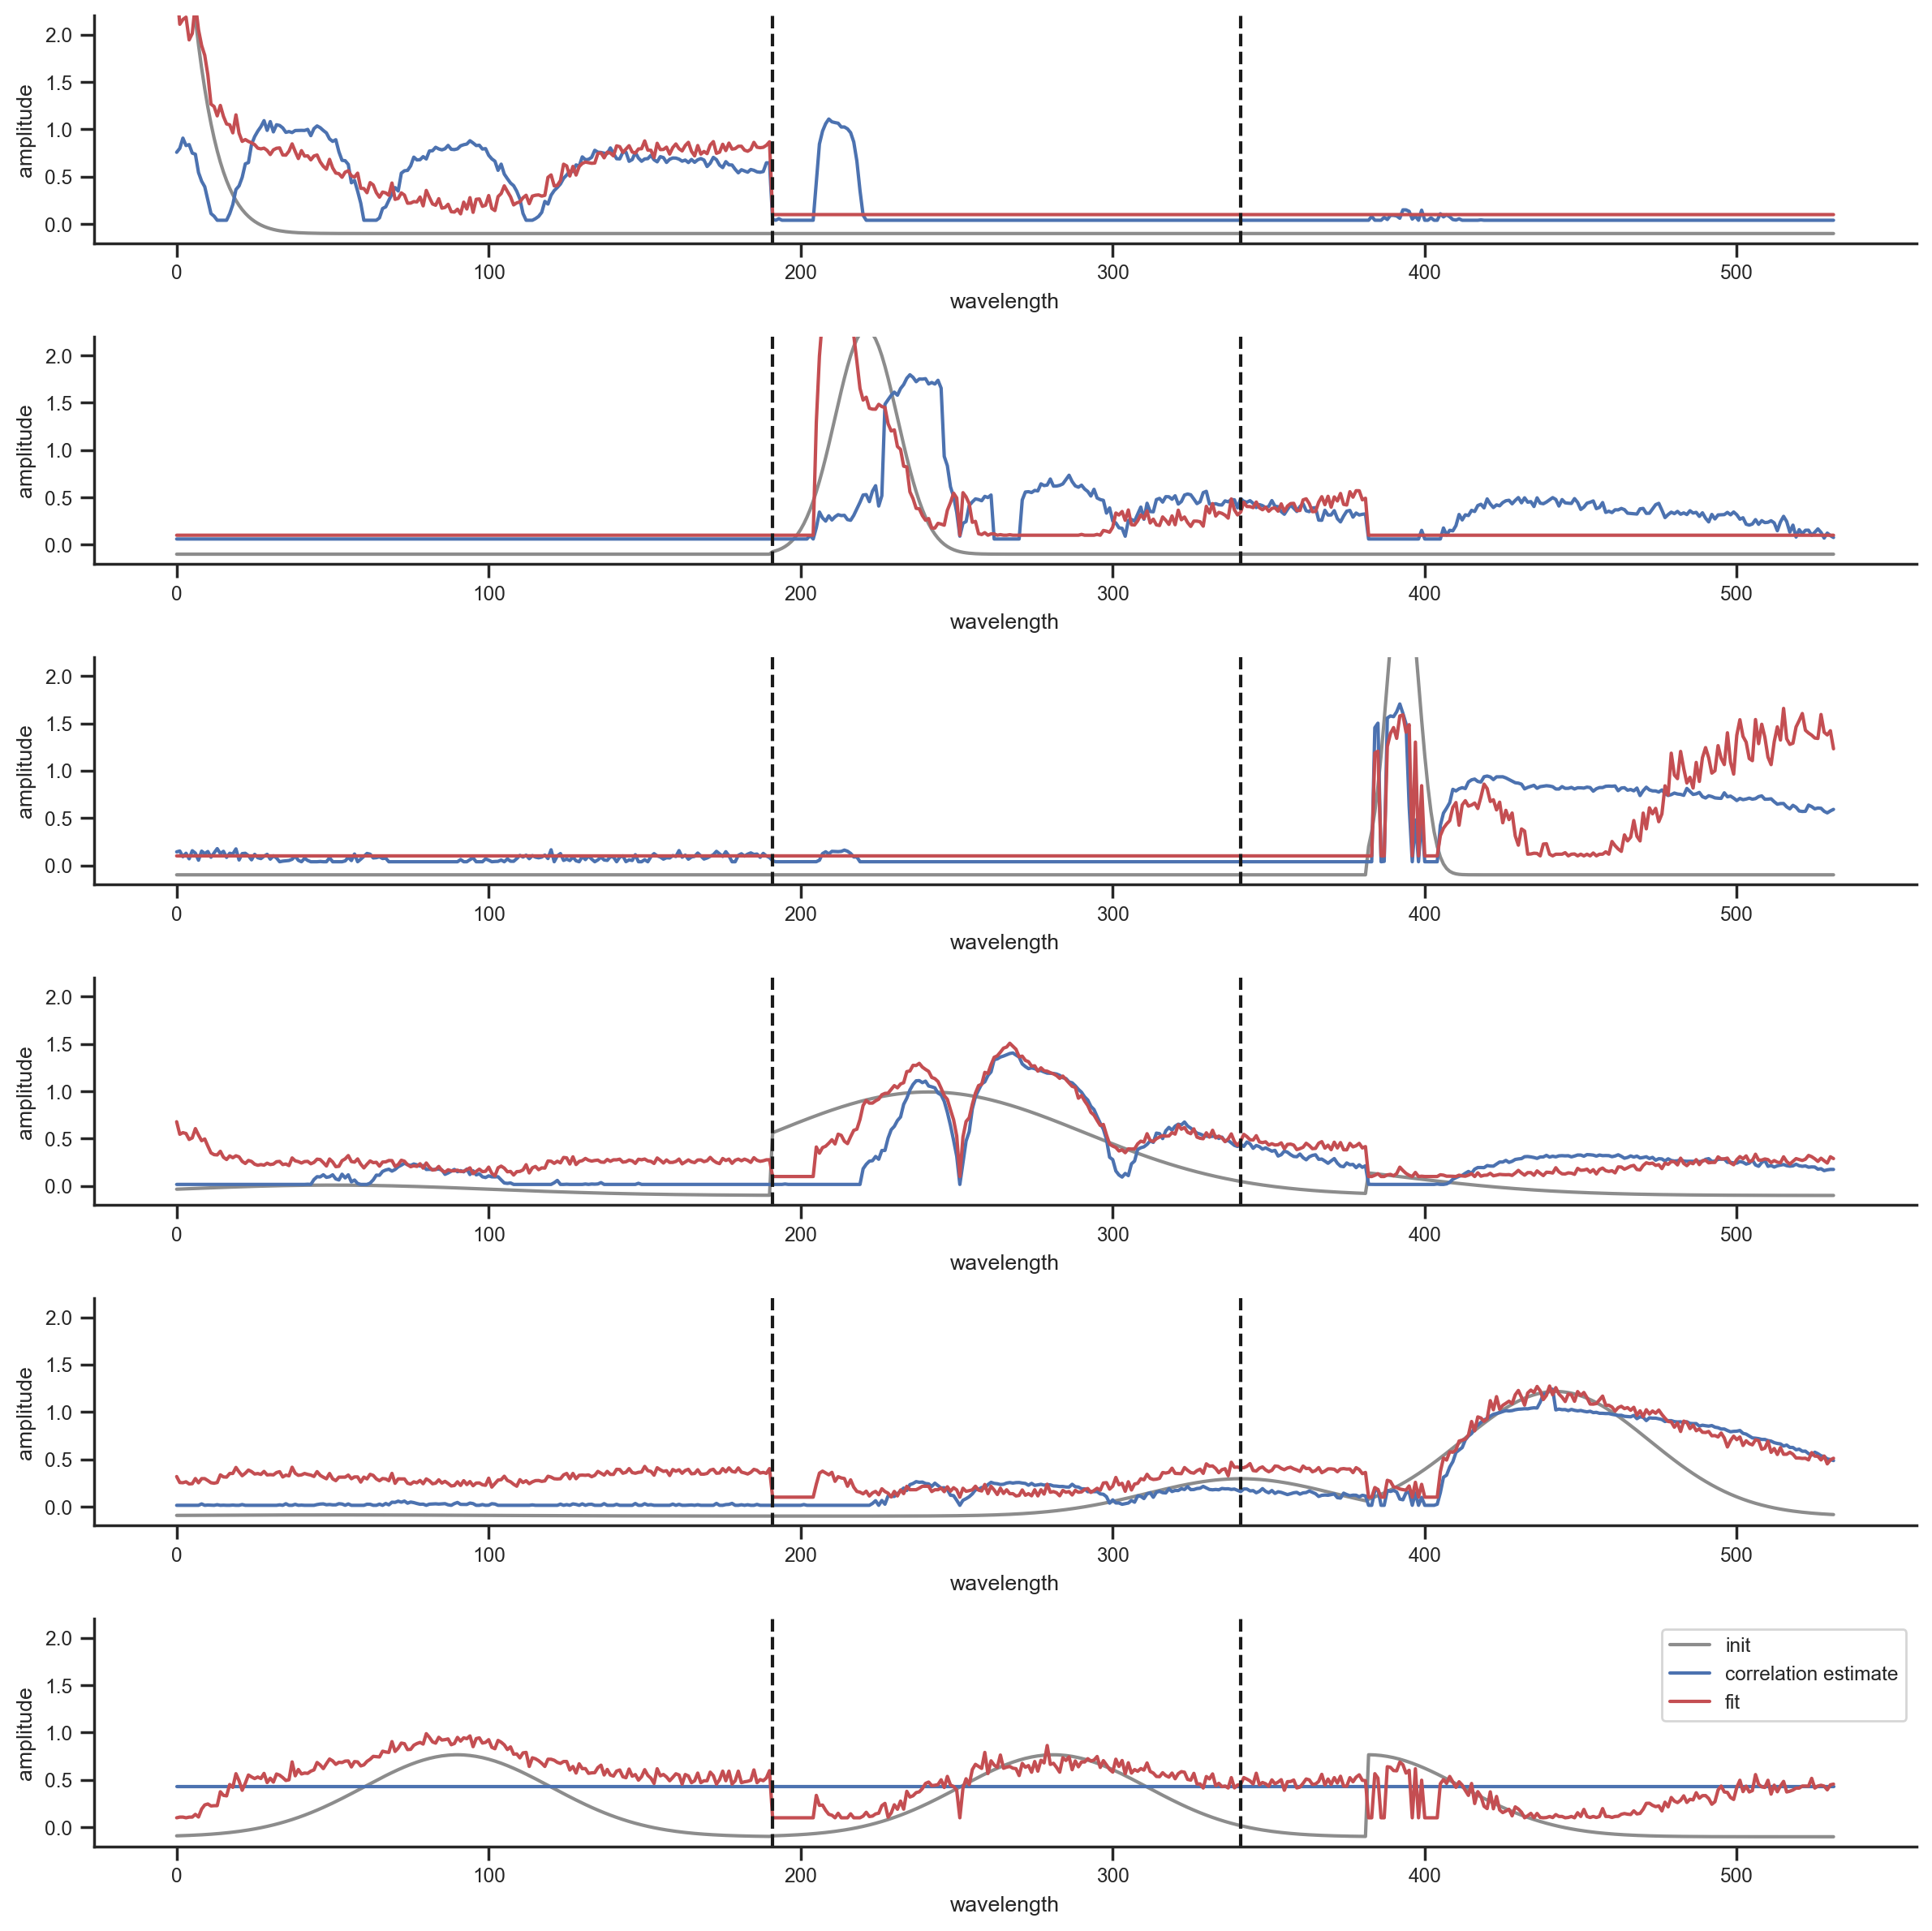

In [26]:
# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_0['A'].copy(), X=res_fine_tune_0['X'].copy(), rank=5,
                                A_keep=dat['A_keep'].copy(), X_keep=None, grad_type=None,
                                step_size_A=0.05, step_size_X=0.05,
                                lam_sparsity_x=0.0, lam_2norm_x=0.00, lam_deviation_x=0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-5, exit_tol=1e-7, max_iter=800)

res_fine_tune_1 = {'A': A.copy(), 'X': X.copy(), 'err': err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_1['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

plot_components(dat, res_fine_tune_1)

In [27]:
# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_1['A'].copy(), X=res_fine_tune_1['X'].copy(), rank=5,
                                A_keep=dat['A_keep'].copy(), X_keep=None, grad_type=None,
                                step_size_A=0.01, step_size_X=0.01,
                                lam_sparsity_x=0.0, lam_2norm_x=0.00, lam_deviation_x=0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-6, exit_tol=1e-7, max_iter=1600)

res_fine_tune_2 = {'A': A.copy(), 'X': X.copy(), 'err': err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_2['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

plot_components(dat, res_fine_tune_2)

X and A are initialized, ignoring rank.


 71%|███████   | 1136/1600 [04:22<01:53,  4.10it/s]

In [ ]:
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_2['A'].copy(), X=res_fine_tune_2['X'].copy(), rank=5,
                                A_keep=dat['A_keep'].copy(), X_keep=None, grad_type=None,
                                step_size_A=0.005, step_size_X=0.005,
                                lam_sparsity_x=0.0, lam_2norm_x=0.00, lam_deviation_x=0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-7, exit_tol=1e-7, max_iter=3200)

res_fine_tune_3 = {'A': A.copy(), 'X': X.copy(), 'err': err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_3['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

plot_components(dat, res_fine_tune_3)

In [ ]:
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_3['A'].copy(), X=res_fine_tune_3['X'].copy(), rank=5,
                                A_keep=dat['A_keep'].copy(), X_keep=None, grad_type=None,
                                step_size_A=0.001, step_size_X=0.001,
                                lam_sparsity_x=0.0, lam_2norm_x=0.00, lam_deviation_x=0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-8, exit_tol=1e-7, max_iter=6400)

res_fine_tune_4 = {'A': A.copy(), 'X': X.copy(), 'err': err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_4['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

plot_components(dat, res_fine_tune_3)